In [12]:
!pip install yfinance ta scikit-learn matplotlib torch --quiet

In [13]:
import numpy as np
!pip install ta
!pip install yfinance
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import ta
import os
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

In [14]:
def fetch_stock_data(symbol='BHARTIARTL.NS', start='2005-01-01', end='2025-01-01'):
    df = yf.download(symbol, start=start, end=end)

    close = df['Close'].squeeze()
    volume = df['Volume'].squeeze()
    high = df['High'].squeeze()
    low = df['Low'].squeeze()

    df['MA20'] = ta.trend.sma_indicator(close, window=20)
    df['MA50'] = ta.trend.sma_indicator(close, window=50)
    df['RSI'] = ta.momentum.rsi(close, window=14)
    df['Volume_MA20'] = volume.rolling(window=20).mean()
    df['ATR_14'] = ta.volatility.average_true_range(high, low, close, window=14)
    df['ADX_14'] = ta.trend.adx(high, low, close, window=14)
    df['BB_WIDTH'] = ta.volatility.bollinger_wband(close, window=20, window_dev=2)

    df.dropna(inplace=True)
    return df

In [15]:
def prepare_data(df):
    features = ['Close', 'MA20', 'MA50', 'RSI','Volume_MA20','ATR_14','ADX_14','BB_WIDTH']
    df = df[features]
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df)

    total_len = len(data_scaled)
    test_size = int(total_len * 0.2)
    test_data = data_scaled[:test_size + 100]
    train_data = data_scaled[test_size:]

    return train_data, test_data, scaler

In [16]:
def create_sequences(data, window=100):
    x, y = [], []
    for i in range(window, len(data)):
        x.append(data[i - window:i])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

In [18]:
def predict_tomorrow_price(symbol, trained_models, window=100):
    df = fetch_stock_data(symbol)
    features = ['Close', 'MA20', 'MA50', 'RSI', 'Volume_MA20', 'ATR_14', 'ADX_14', 'BB_WIDTH']
    df = df[features].dropna()

    best_r2 = -np.inf
    best_prediction = None

    for entry in trained_models:
        model = entry['model']
        scaler = entry['scaler']
        try:
            data_scaled = scaler.transform(df)
        except:
            continue

        if len(data_scaled) < window:
            continue

        last_window = data_scaled[-window:]
        last_window = last_window.reshape(1, window, data_scaled.shape[1])

        y_pred_scaled = model.predict(last_window, verbose=0).flatten()[0]
        close_scale = scaler.scale_[0]
        close_min = scaler.min_[0]
        y_pred = y_pred_scaled / close_scale + close_min


        x_recent, y_true = create_sequences(data_scaled, window)
        y_pred_recent = model.predict(x_recent, verbose=0).flatten()
        y_true = np.array(y_true)

        y_pred_recent = y_pred_recent / close_scale + close_min
        y_true = y_true / close_scale + close_min
        r2 = r2_score(y_true, y_pred_recent)

        if r2 > best_r2:
            best_r2 = r2
            best_prediction = {
                'model_symbol': entry['symbol'],
                'predicted_price': y_pred,
                'r2': r2
            }

    if best_prediction:
        print(f" Tomorrow's predicted price for {symbol}: ₹{best_prediction['predicted_price']:.2f}")
        print(f"Used model trained on: {best_prediction['model_symbol']} | R² Score: {best_prediction['r2']:.4f}")
        return best_prediction['predicted_price']
    else:
        print(" No suitable model found for prediction.")
        return None

In [19]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(60, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(80, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(120))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [20]:
def train_and_save_models(symbols, model_dir='models'):
    os.makedirs(model_dir, exist_ok=True)
    for symbol in symbols:
        print(f"Training on {symbol}")
        df = fetch_stock_data(symbol)
        train_data, _, scaler = prepare_data(df)
        x_train, y_train = create_sequences(train_data)

        model = build_lstm_model(input_shape=(x_train.shape[1], x_train.shape[2]))
        model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

        model.save(os.path.join(model_dir, f"{symbol}_model.h5"))
        with open(os.path.join(model_dir, f"{symbol}_scaler.pkl"), 'wb') as f:
            pickle.dump(scaler, f)

In [21]:
def load_models(symbols, model_dir='models'):
    models = []
    for symbol in symbols:
        model = load_model(os.path.join(model_dir, f"{symbol}_model.h5"))
        with open(os.path.join(model_dir, f"{symbol}_scaler.pkl"), 'rb') as f:
            scaler = pickle.load(f)
        models.append({'symbol': symbol, 'model': model, 'scaler': scaler})
    return models

In [22]:
def predict_new_stock_best(symbol, start, end, trained_models, window=100):
    df = fetch_stock_data(symbol, start, end)
    features = ['Close', 'MA20', 'MA50', 'RSI', 'Volume_MA20', 'ATR_14', 'ADX_14', 'BB_WIDTH']
    df = df[features].dropna()

    best_r2 = -np.inf
    best_result = None

    for entry in trained_models:
        model, scaler = entry['model'], entry['scaler']
        try:
            data_scaled = scaler.transform(df)
        except:
            continue

        x_new, y_true = create_sequences(data_scaled, window)
        y_pred_scaled = model.predict(x_new, verbose=1).flatten()

        close_scale = scaler.scale_[0]
        close_min = scaler.min_[0]
        y_pred = y_pred_scaled / close_scale + close_min
        y_true_rescaled = y_true / close_scale + close_min

        r2 = r2_score(y_true_rescaled, y_pred)

        if r2 > best_r2:
            best_r2 = r2
            best_result = {
                'symbol': entry['symbol'],
                'r2': r2,
                'y_pred': y_pred,
                'y_true': y_true_rescaled,
                'df': df
            }

    if best_result:
        print(f"Best Model: {best_result['symbol']} | R^2: {best_result['r2']:.4f}")
        plt.figure(figsize=(14, 7))
        plt.plot(best_result['y_true'], label='Actual')
        plt.plot(best_result['y_pred'], label='Predicted')
        plt.title(f"Prediction for {symbol} using best model")
        plt.legend()
        plt.show()

        return best_result['y_pred'], best_result['y_true'], best_result['df']
    else:
        print("No suitable model found.")
        return None, None, None

In [23]:
if __name__ == "__main__":
    group_less = ['MAXHEALTH.NS', 'IDEA.NS', 'ITC.NS', 'TATAMOTORS.NS']
    group_mid = ['ICICIBANK.NS', 'HDFCBANK.NS','SIEMENS.NS', 'HEROMOTOCO.NS']
    group_more = [ 'MRF.NS', 'BAJFINANCE.NS', 'POWERINDIA.NS', 'PAGEIND.NS']

    all_symbols = list(set(group_less + group_more + group_mid))
    train_and_save_models(all_symbols)

    # # To predict for stock using X models
    # x_models = load_models(group_less)
    # predict_new_stock_best("HCLTECH.NS", "2020-01-01", "2025-01-01", trained_models=x_models)

    # # To predict for stock using Y models
    # y_models = load_models(group_more)
    # predict_new_stock_best("BPCL.NS", "2020-01-01", "2025-01-01", trained_models=y_models)

Training on ITC.NS


/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0237
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0032
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0031
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0026
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0030
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0020
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0019
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0018
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0016
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0017
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0015
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0016
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s

/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


Training on HDFCBANK.NS


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0273
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0048
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0041
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0035
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0035
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0038
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0031
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0028
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0028
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0028
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0027
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0026
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0022
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0021
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on ICICIBANK.NS


/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0185
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0033
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0025
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0022
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0022
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0022
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0021
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0018
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0014
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0018
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0015
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0017
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on POWERINDIA.NS


/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0517
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0110
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0056
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0067
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0057
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0044
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0038
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0061
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0034
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0038
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0036
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0040
Epoc

Training on MRF.NS


/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0288
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0036
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0030
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0027
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0024
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0026
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0023
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0023
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0019
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0016
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0021
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0015
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0015
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on MAXHEALTH.NS


/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0776
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0117
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0100
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0052
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0068
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0045
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0053
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0055
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0042
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0047
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0057
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0044
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0061
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0049
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0049
Epoch 16/50
23/

Training on SIEMENS.NS


/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0124
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0021
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0019
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0020
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0023
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0015
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0013
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0013
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0011
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0014
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0014
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0010
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0010
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on HEROMOTOCO.NS


/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0200
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0027
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0023
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0020
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0020
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0016
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0015
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0014
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0016
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0011
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0011
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on TATAMOTORS.NS


/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0149
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0033
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0023
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0026
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0016
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0013
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0013
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0014
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0013
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0012
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0010
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on BAJFINANCE.NS


/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0325
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0053
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0041
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0039
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0033
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0032
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0027
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0028
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0027
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0026
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0027
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0026
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0022
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0022
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on IDEA.NS


/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0244
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0046
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0044
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0039
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0033
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0028
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0034
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0025
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0024
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0026
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0023
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0023
Epoch 13/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0020
Epoch 14/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0022
Epoch 15/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on PAGEIND.NS


/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0261
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0048
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0045
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0037
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0030
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0029
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0026
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0023
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0026
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0022
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0022
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0021
Epoch 13/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0019
Epoch 14/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0023
Epoch 15/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


ADANIENT.NS Latest Price: ₹2277.699951171875
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Best Model: SIEMENS.NS | R^2: 0.9223


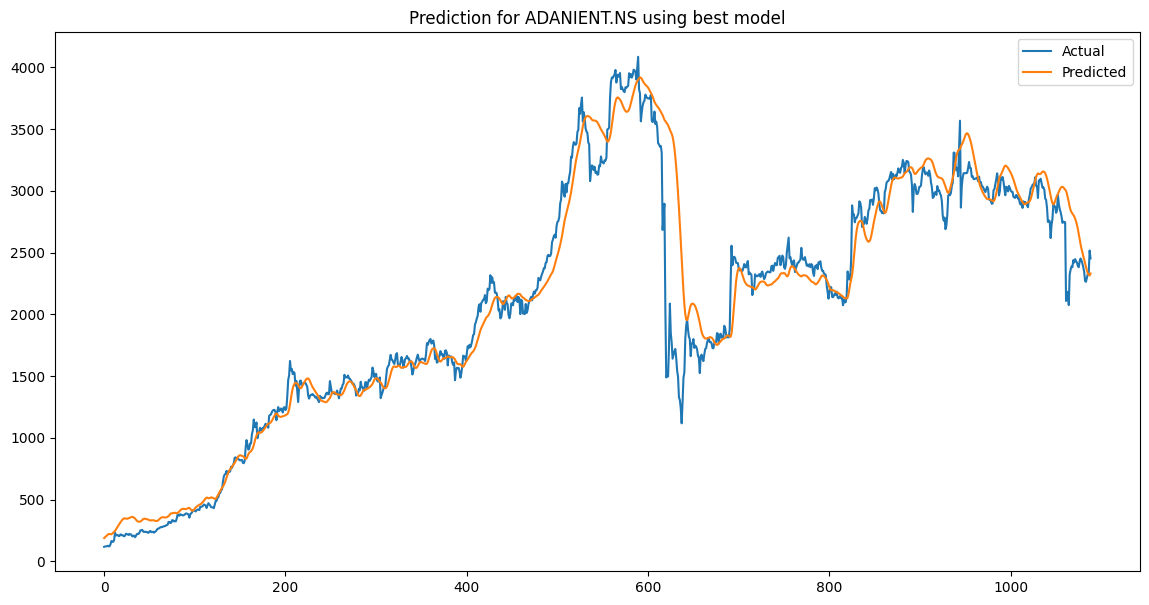

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


ADANIPORTS.NS Latest Price: ₹1504.0
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Best Model: ICICIBANK.NS | R^2: 0.9713


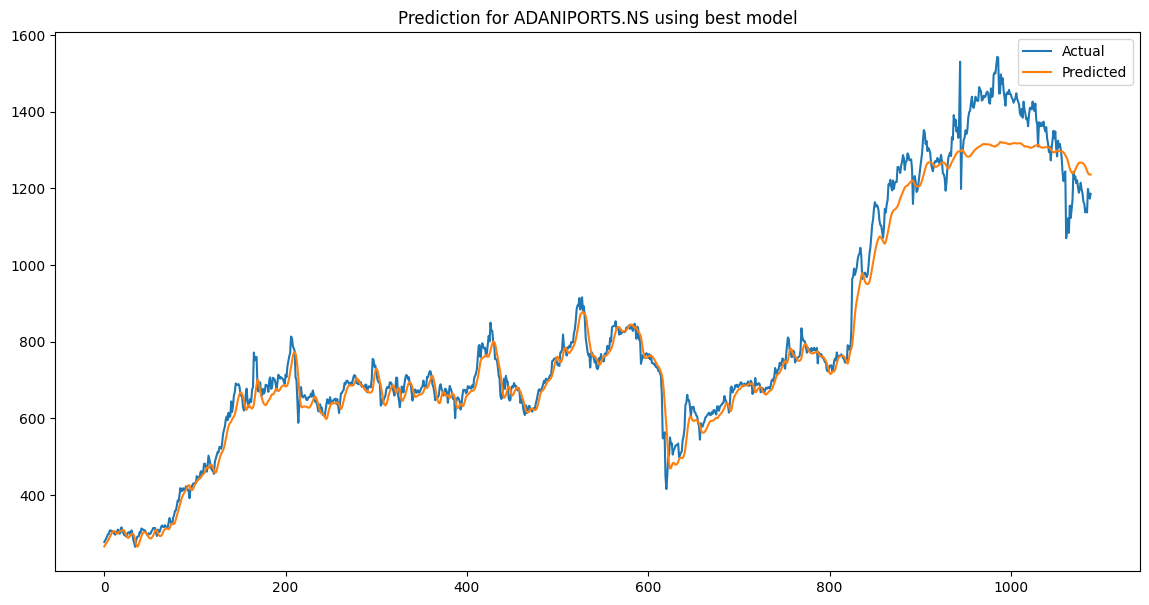

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


APOLLOHOSP.NS Latest Price: ₹7009.5
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Best Model: PAGEIND.NS | R^2: -0.4641


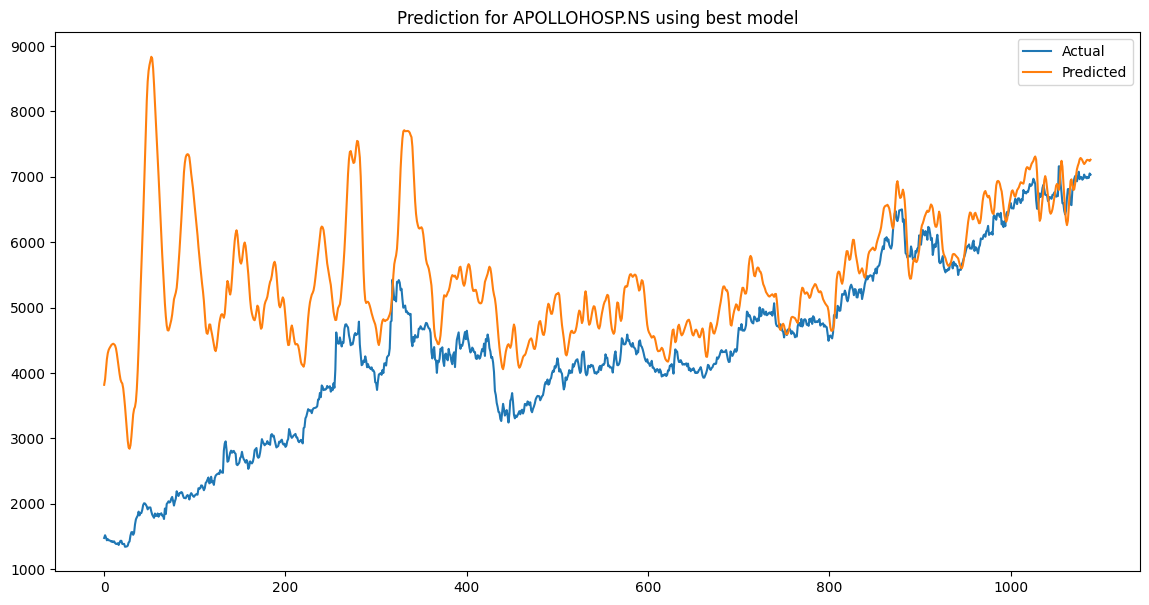

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


ASIANPAINT.NS Latest Price: ₹2779.39990234375
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Best Model: HEROMOTOCO.NS | R^2: 0.9125


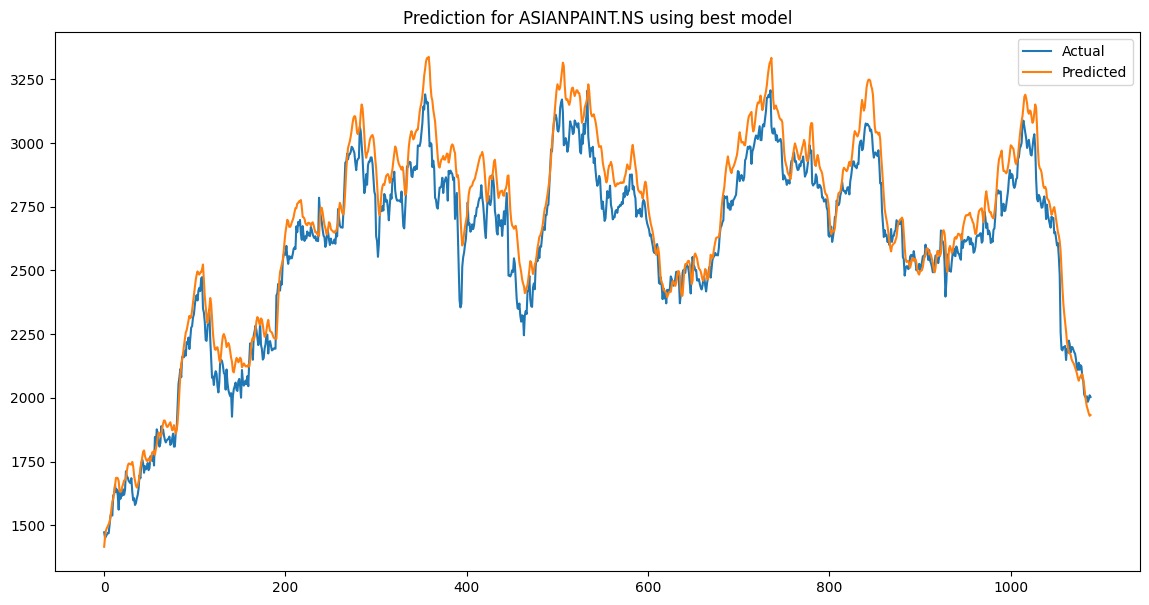

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


AXISBANK.NS Latest Price: ₹1272.699951171875
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Best Model: ICICIBANK.NS | R^2: 0.9843


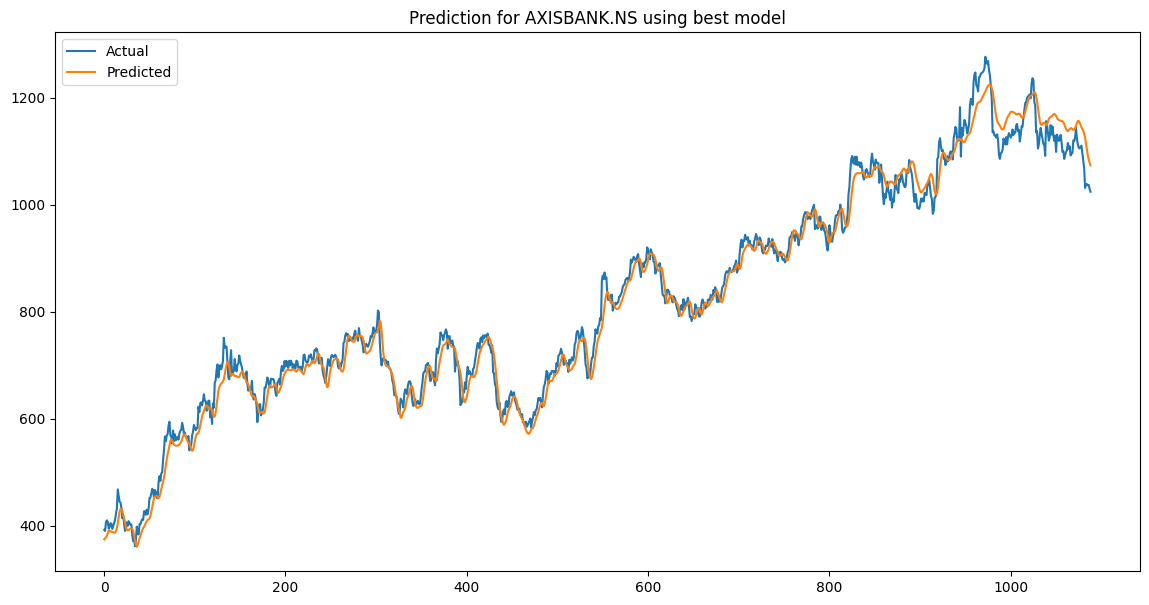

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


BAJAJ-AUTO.NS Latest Price: ₹9053.5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Best Model: PAGEIND.NS | R^2: 0.8535


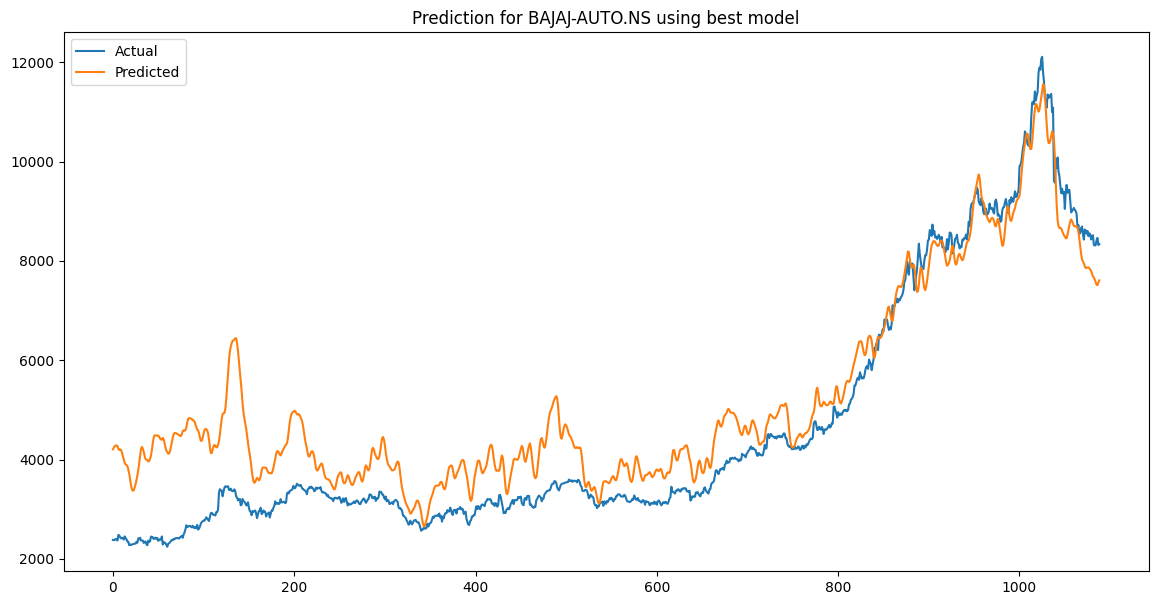

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


BAJFINANCE.NS Latest Price: ₹1006.4000244140625
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Best Model: ICICIBANK.NS | R^2: 0.9698


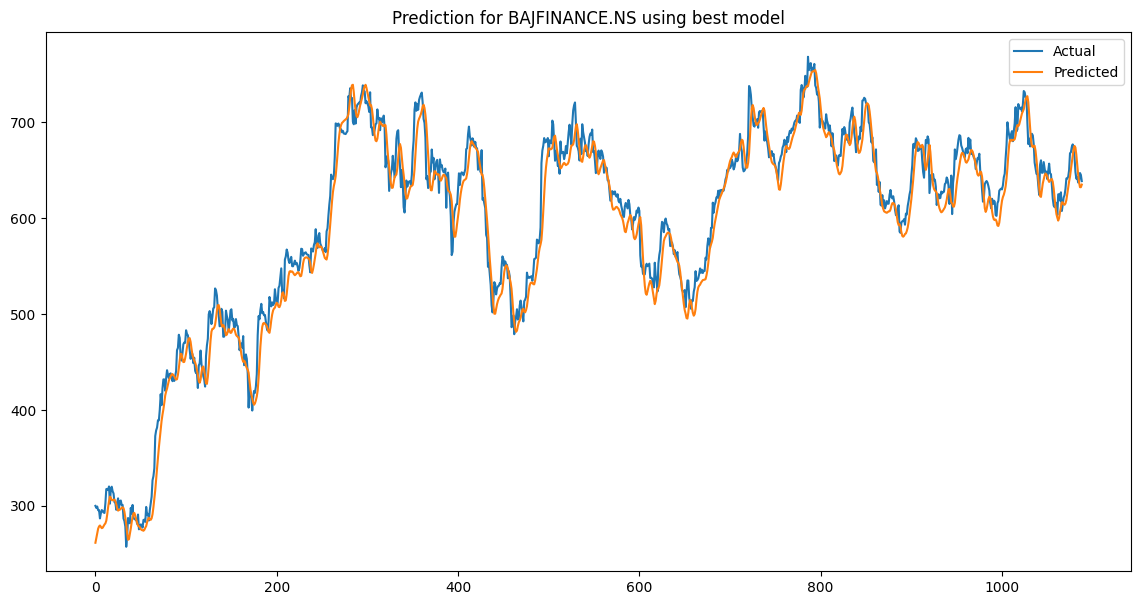

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


BAJAJFINSV.NS Latest Price: ₹2065.800048828125
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Best Model: SIEMENS.NS | R^2: 0.9604


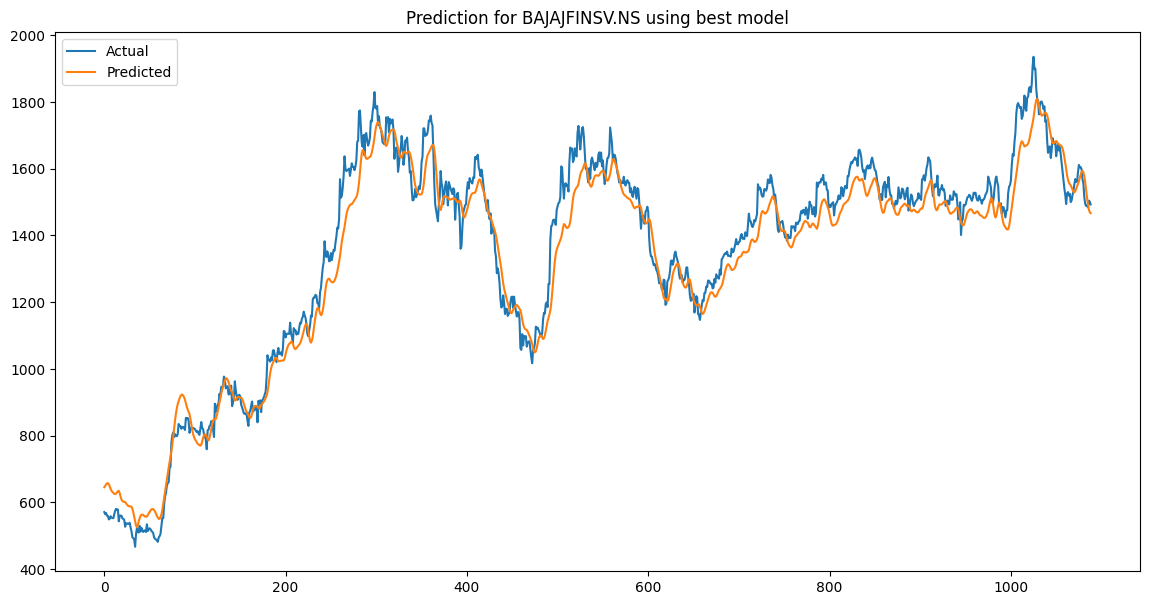

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


BPCL.NS Latest Price: ₹351.29998779296875
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
Best Model: ITC.NS | R^2: 0.9749


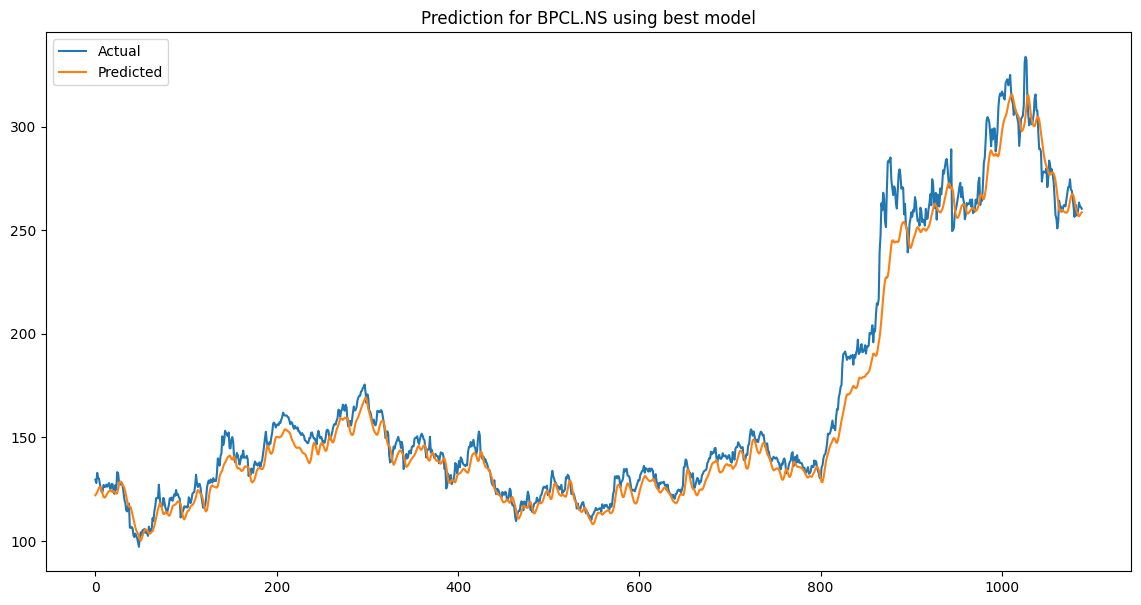

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


BHARTIARTL.NS Latest Price: ₹2053.199951171875
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best Model: ICICIBANK.NS | R^2: 0.9480


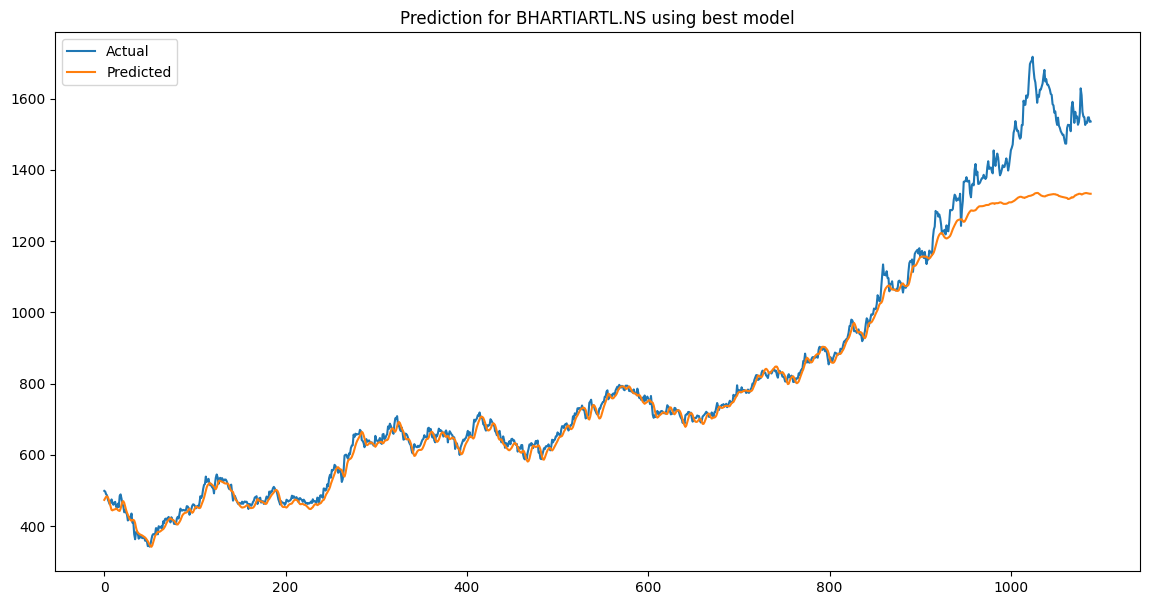

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


BRITANNIA.NS Latest Price: ₹5847.0
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Best Model: PAGEIND.NS | R^2: 0.2821


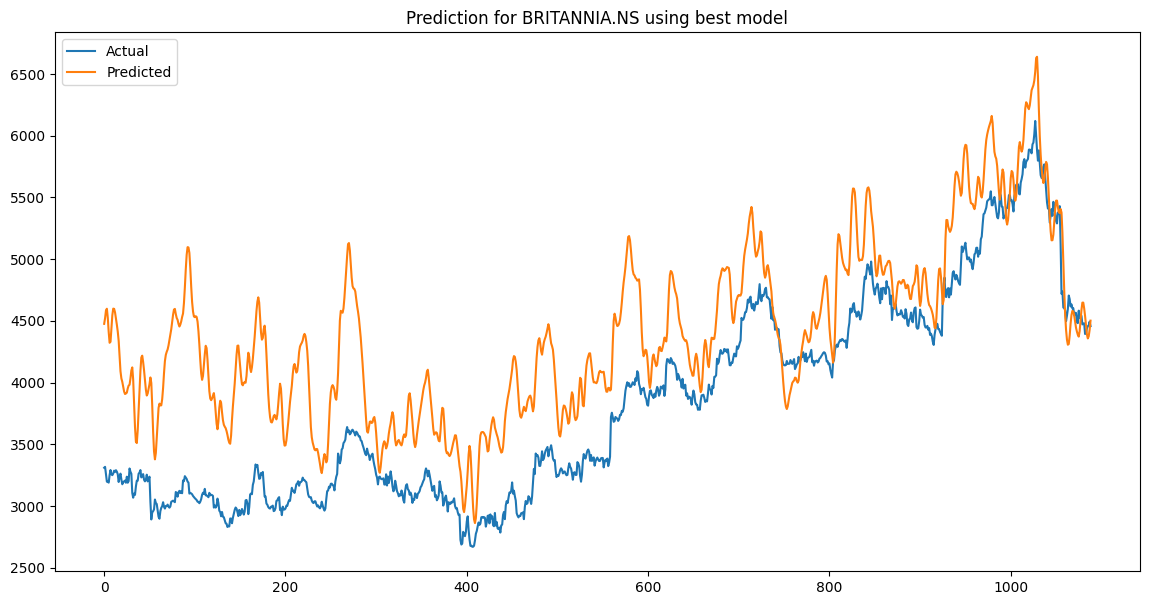

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


CIPLA.NS Latest Price: ₹1512.300048828125
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Best Model: SIEMENS.NS | R^2: 0.9761


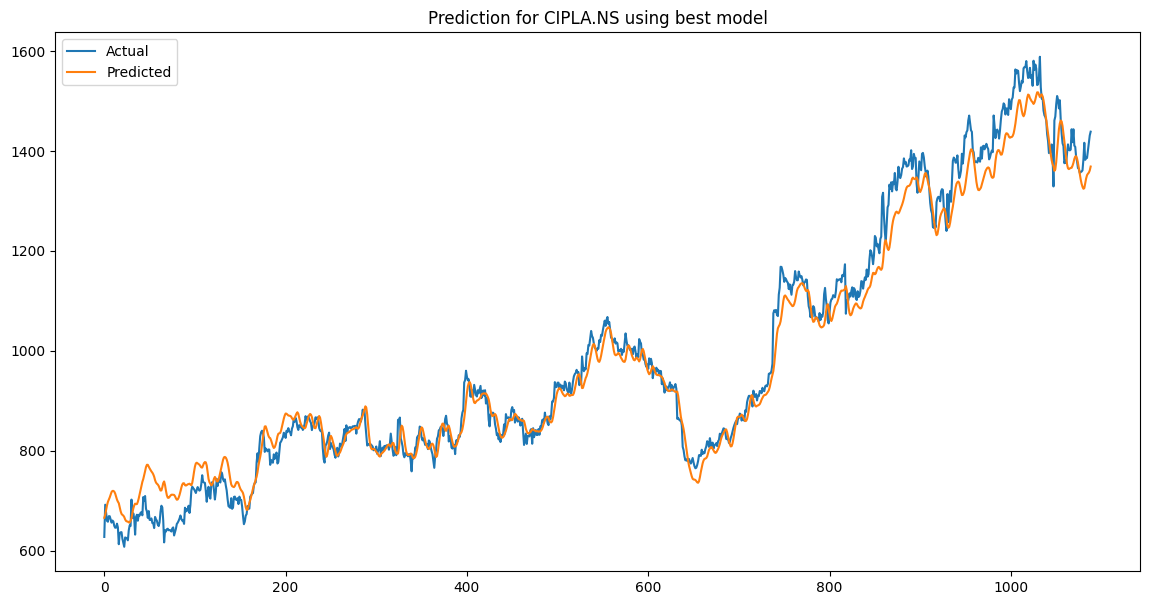

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


COALINDIA.NS Latest Price: ₹384.0
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Best Model: ITC.NS | R^2: 0.9908


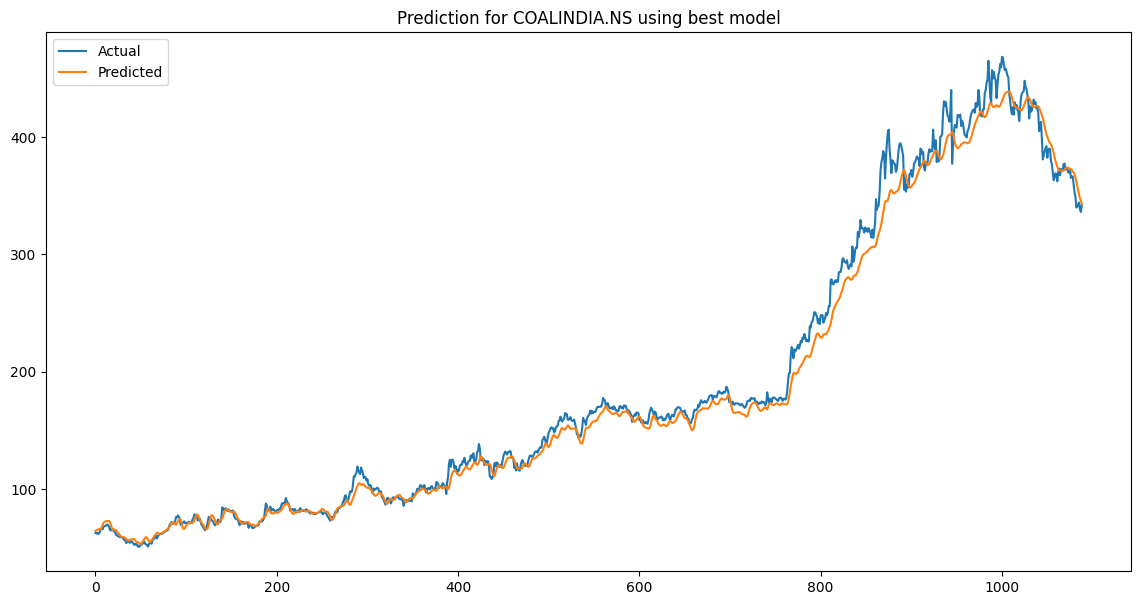

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


DIVISLAB.NS Latest Price: ₹6430.0
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best Model: PAGEIND.NS | R^2: -2.4344


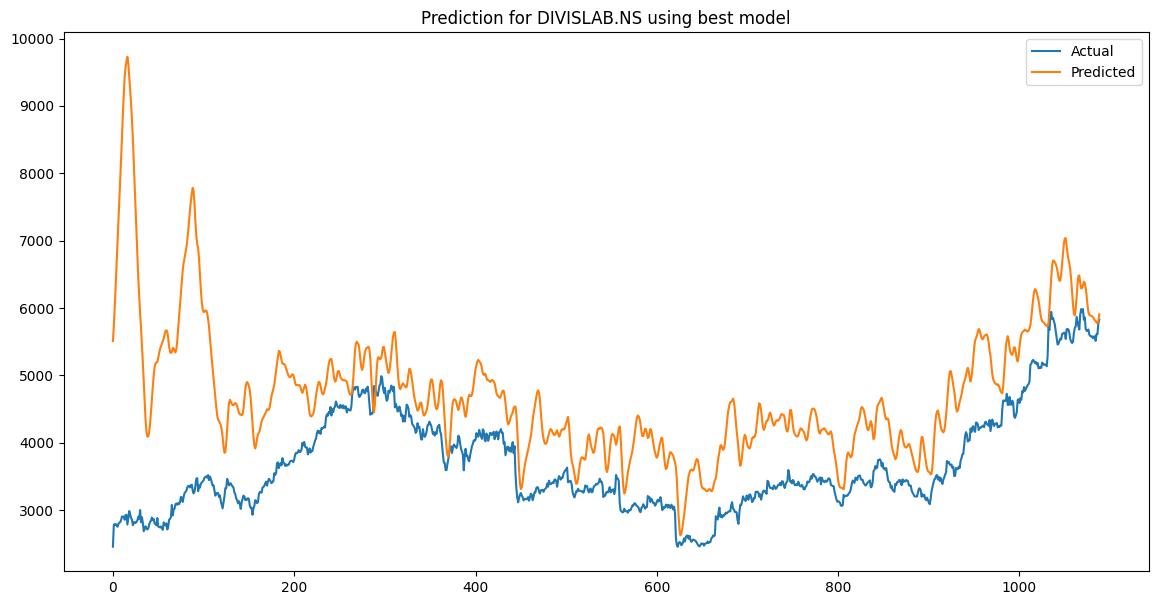

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

DRREDDY.NS Latest Price: ₹1273.5
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Best Model: ICICIBANK.NS | R^2: 0.9664


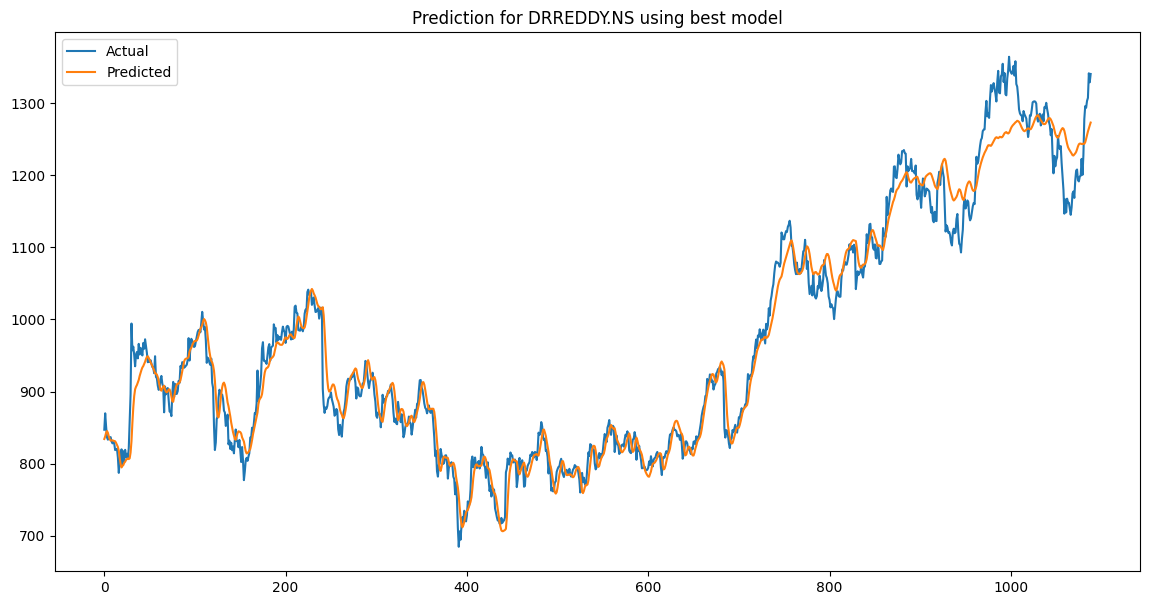

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


EICHERMOT.NS Latest Price: ₹7256.0
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best Model: PAGEIND.NS | R^2: -5.7633


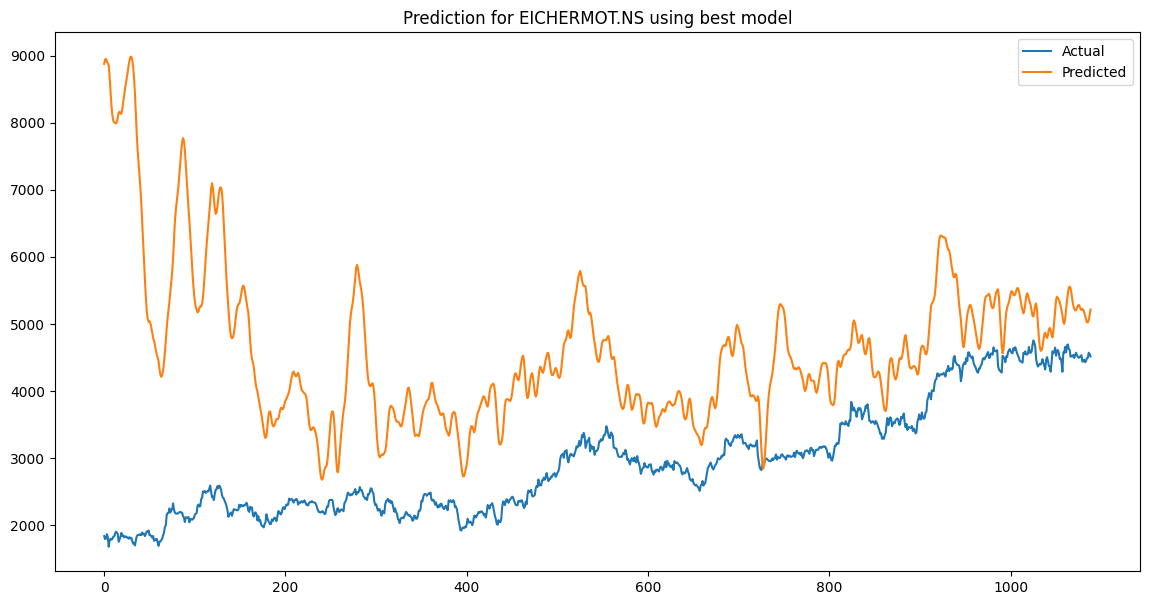

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


GRASIM.NS Latest Price: ₹2797.800048828125
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best Model: SIEMENS.NS | R^2: 0.9844


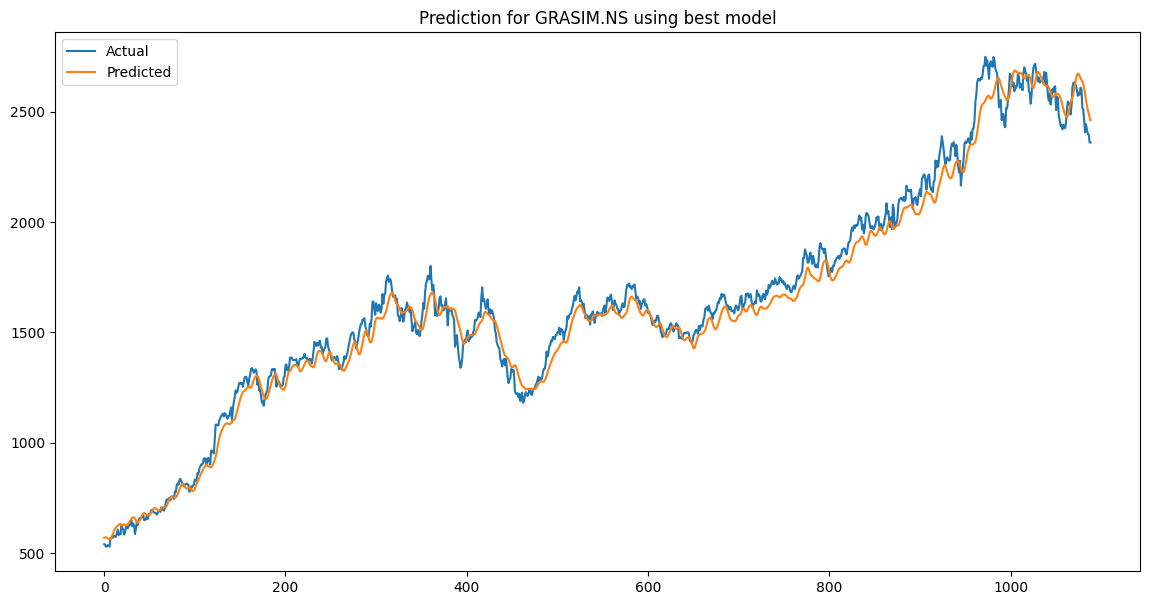

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


HCLTECH.NS Latest Price: ₹1672.4000244140625
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Best Model: SIEMENS.NS | R^2: 0.9751


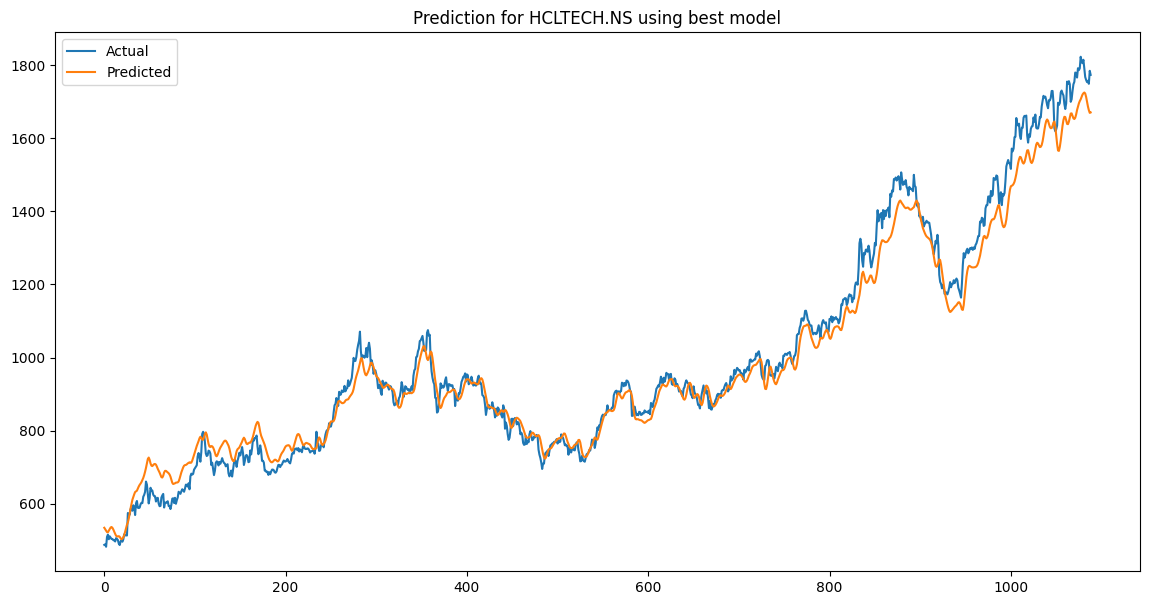

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


HDFCBANK.NS Latest Price: ₹1000.2999877929688
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best Model: ICICIBANK.NS | R^2: 0.9333


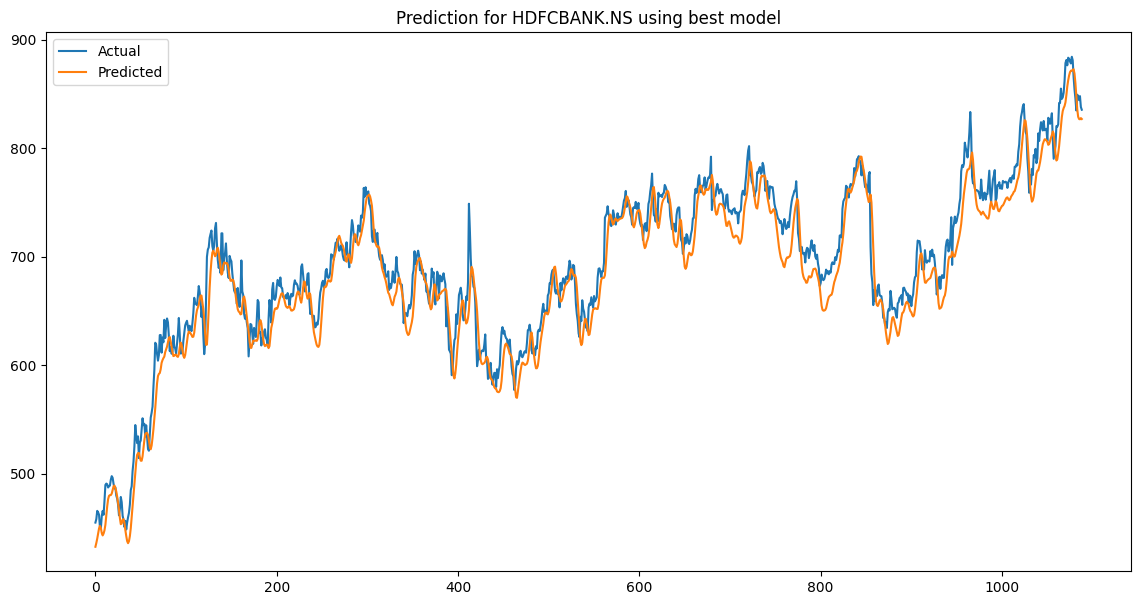

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


HEROMOTOCO.NS Latest Price: ₹5979.5
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best Model: PAGEIND.NS | R^2: -1.9783


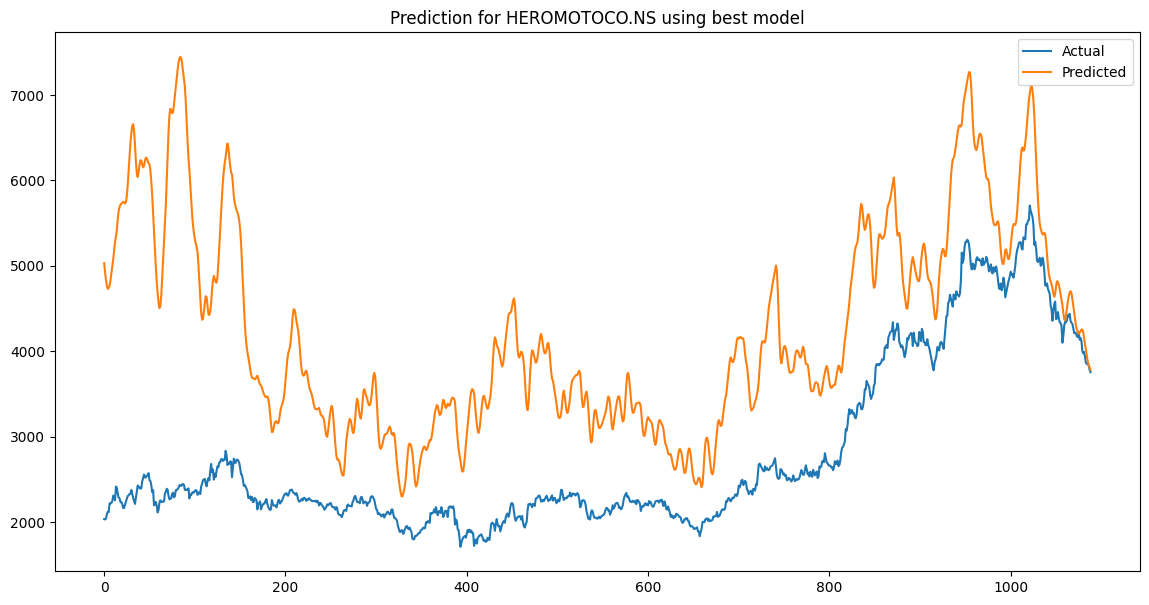

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


HINDALCO.NS Latest Price: ₹824.3499755859375
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: ICICIBANK.NS | R^2: 0.9857


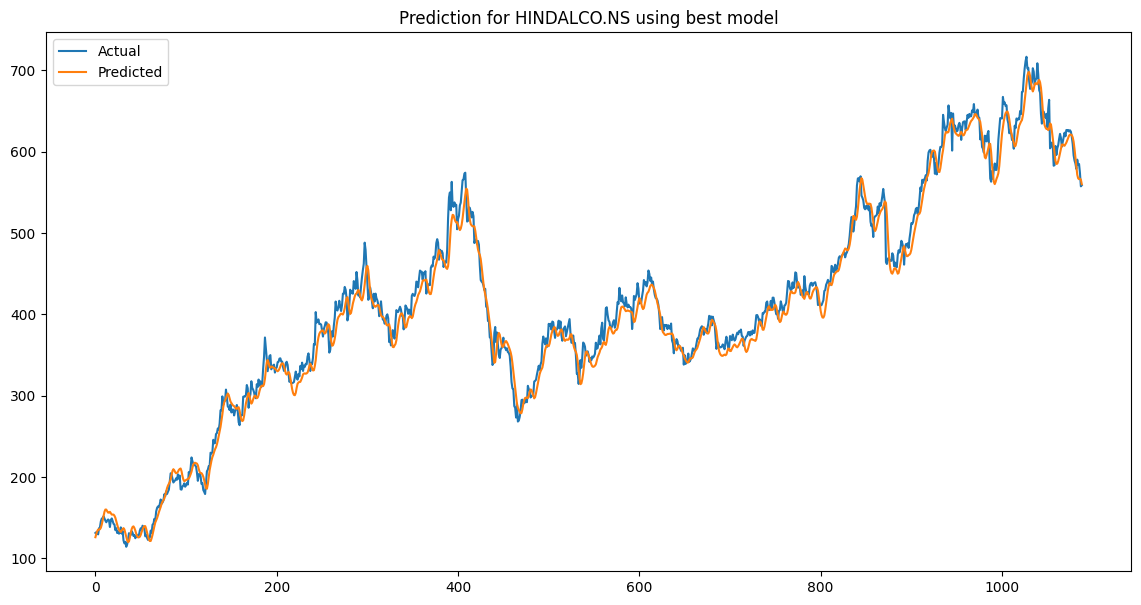

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


HINDUNILVR.NS Latest Price: ₹2305.60009765625
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best Model: HEROMOTOCO.NS | R^2: 0.9366


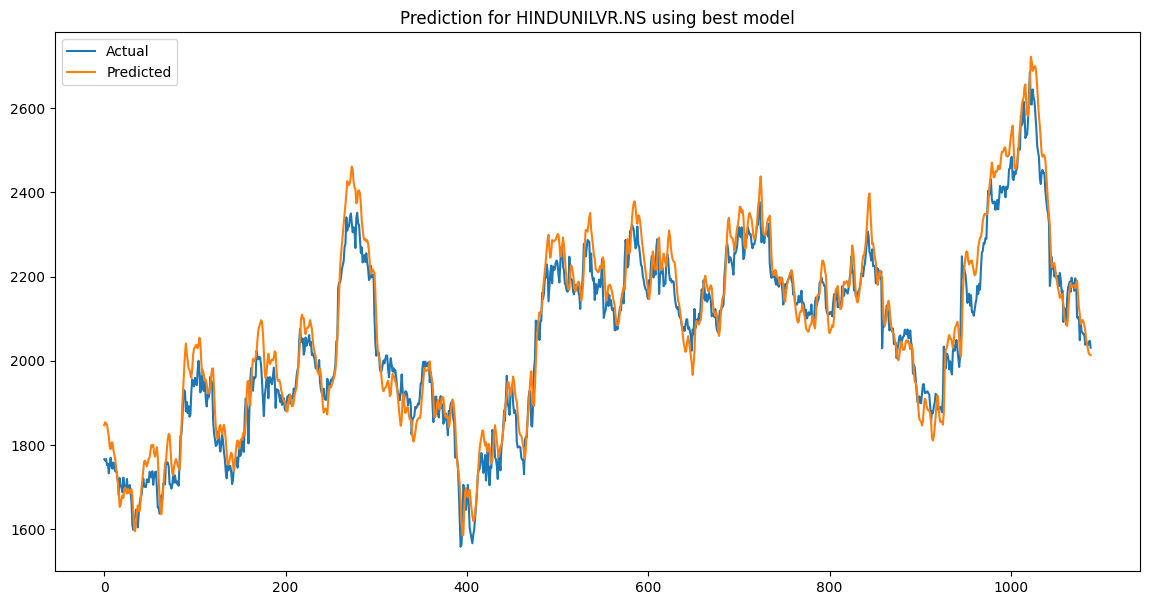

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


ICICIBANK.NS Latest Price: ₹1360.0
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Best Model: ICICIBANK.NS | R^2: 0.9937


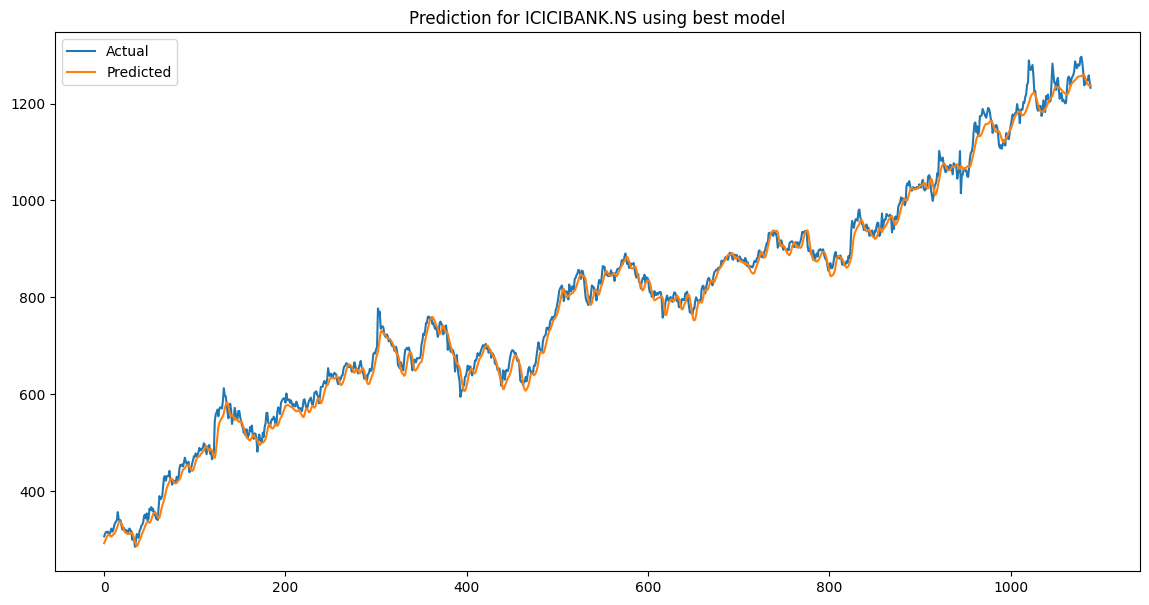

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


ITC.NS Latest Price: ₹402.8999938964844
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: ITC.NS | R^2: 0.9937


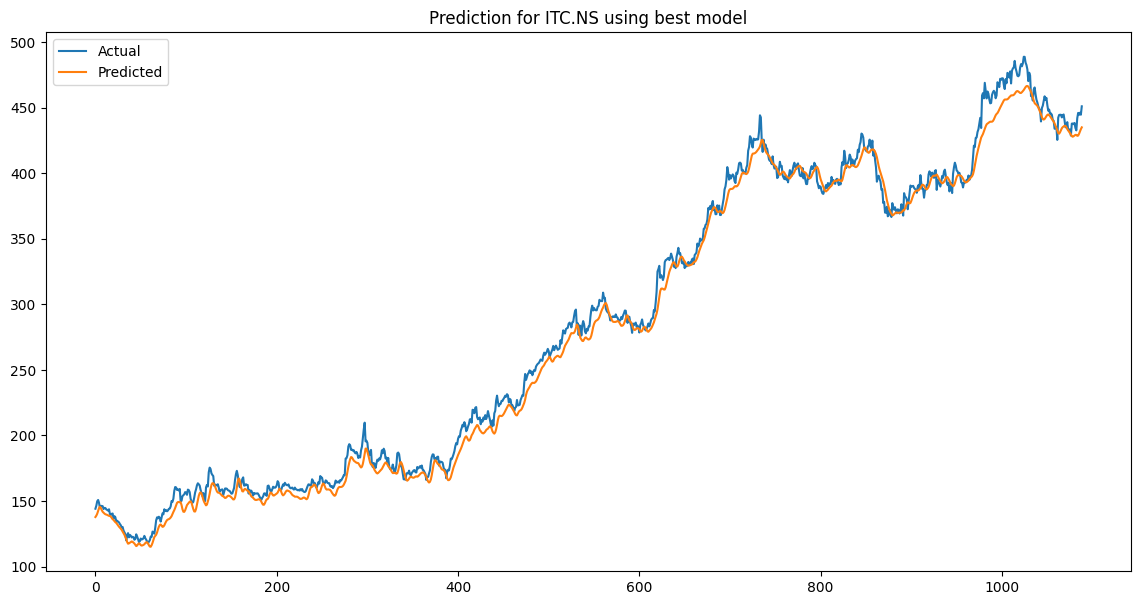

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


INDUSINDBK.NS Latest Price: ₹835.5499877929688
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best Model: ICICIBANK.NS | R^2: 0.9057


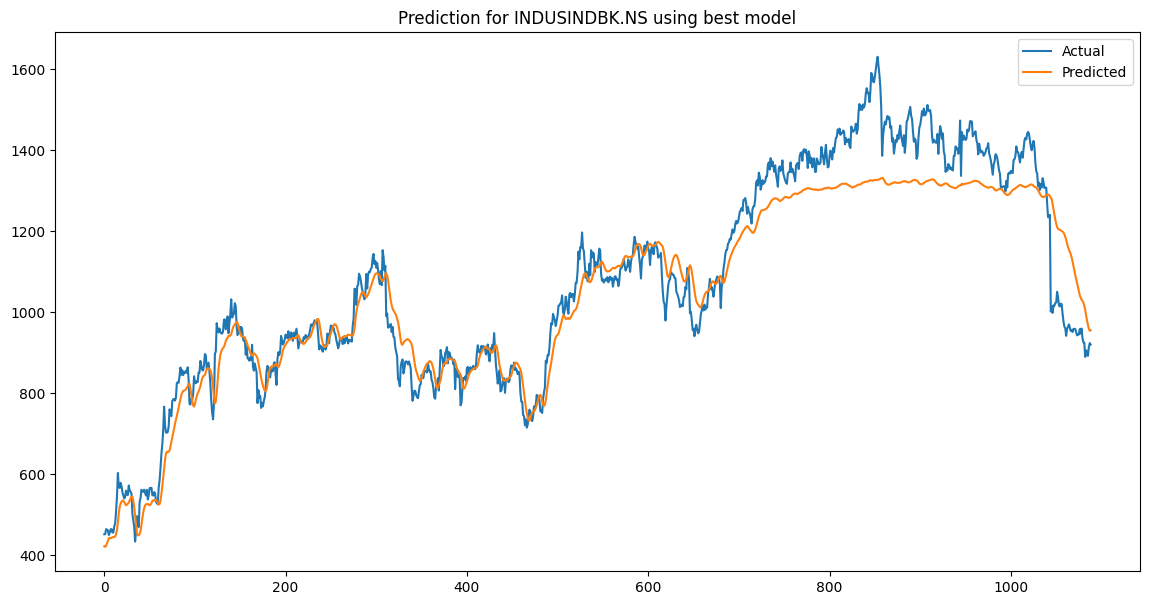

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


INFY.NS Latest Price: ₹1598.0
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: SIEMENS.NS | R^2: 0.8813


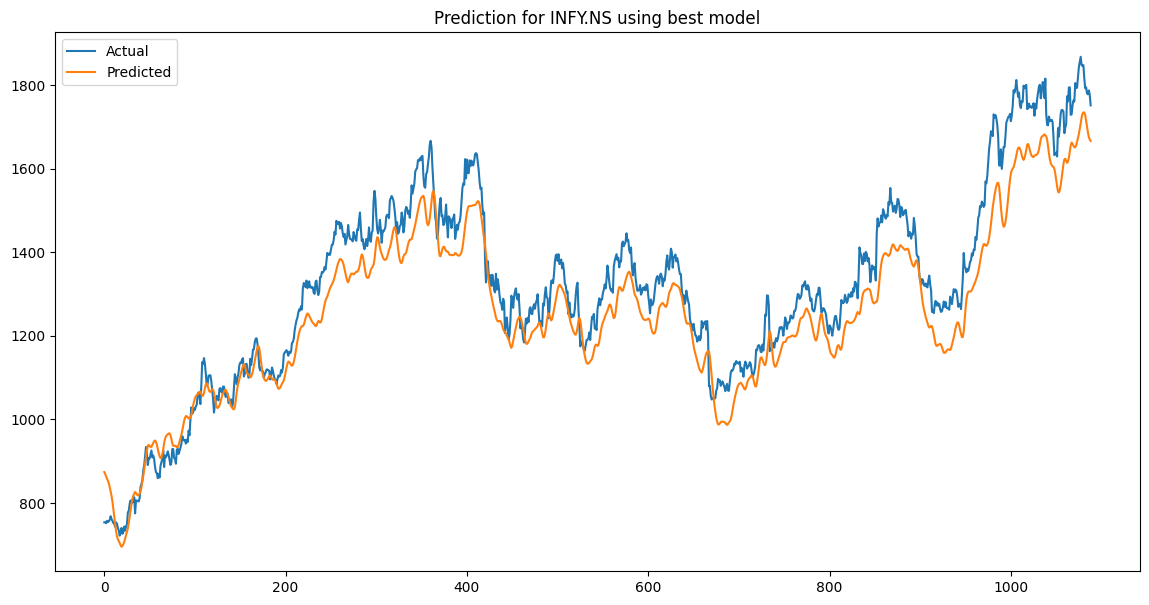

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


JSWSTEEL.NS Latest Price: ₹1105.4000244140625
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: ICICIBANK.NS | R^2: 0.9882


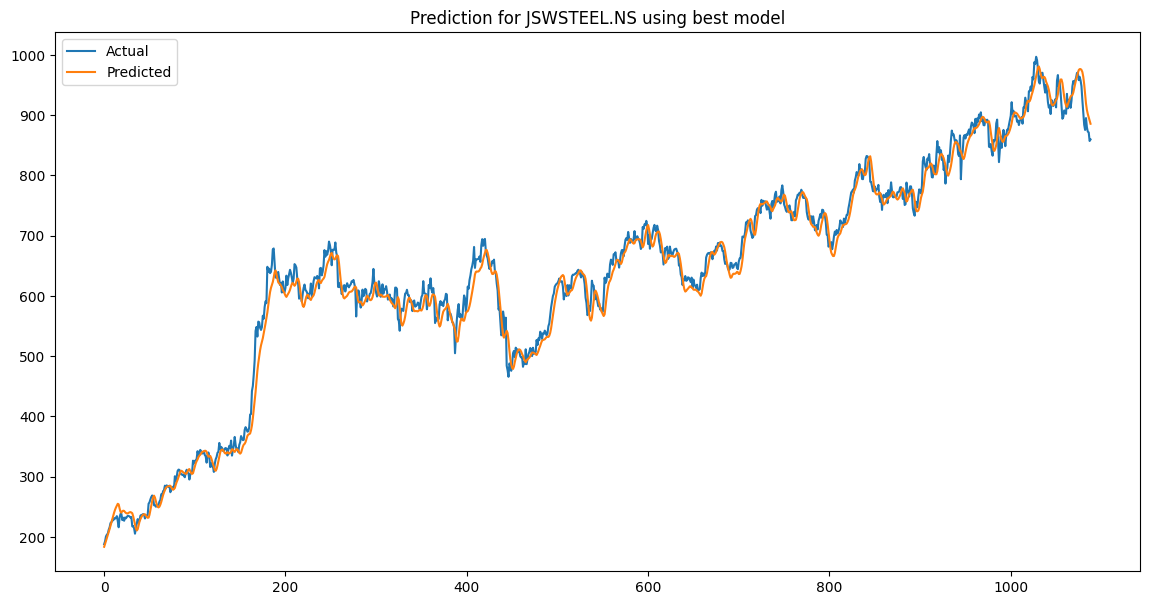

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


KOTAKBANK.NS Latest Price: ₹2180.199951171875
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Best Model: SIEMENS.NS | R^2: 0.4679


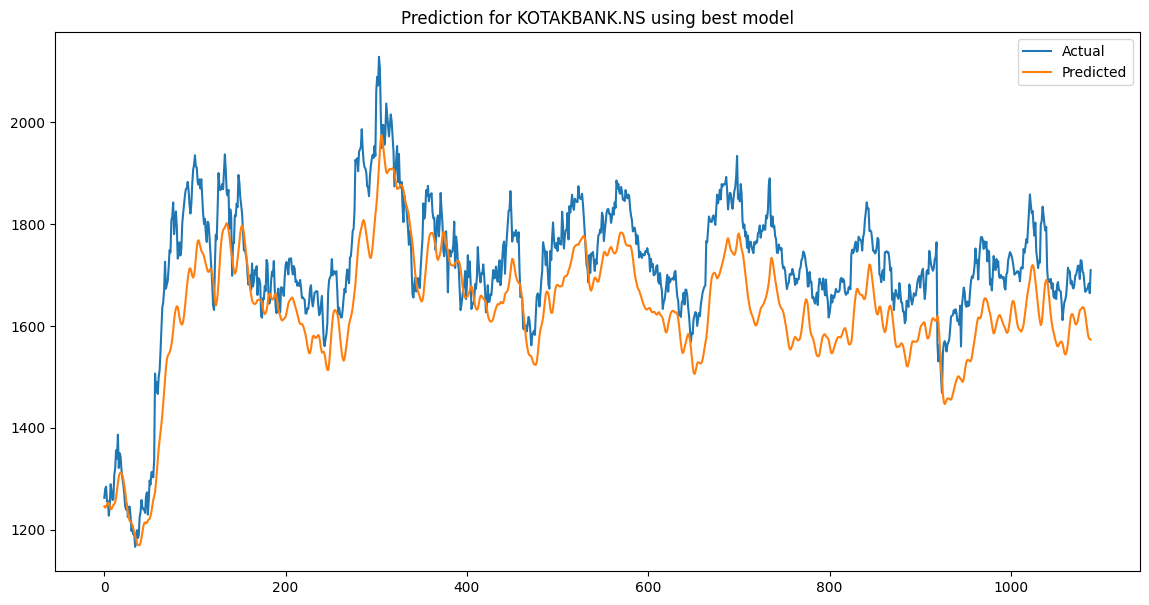

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


LT.NS Latest Price: ₹4003.89990234375
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: BAJFINANCE.NS | R^2: -2.9387


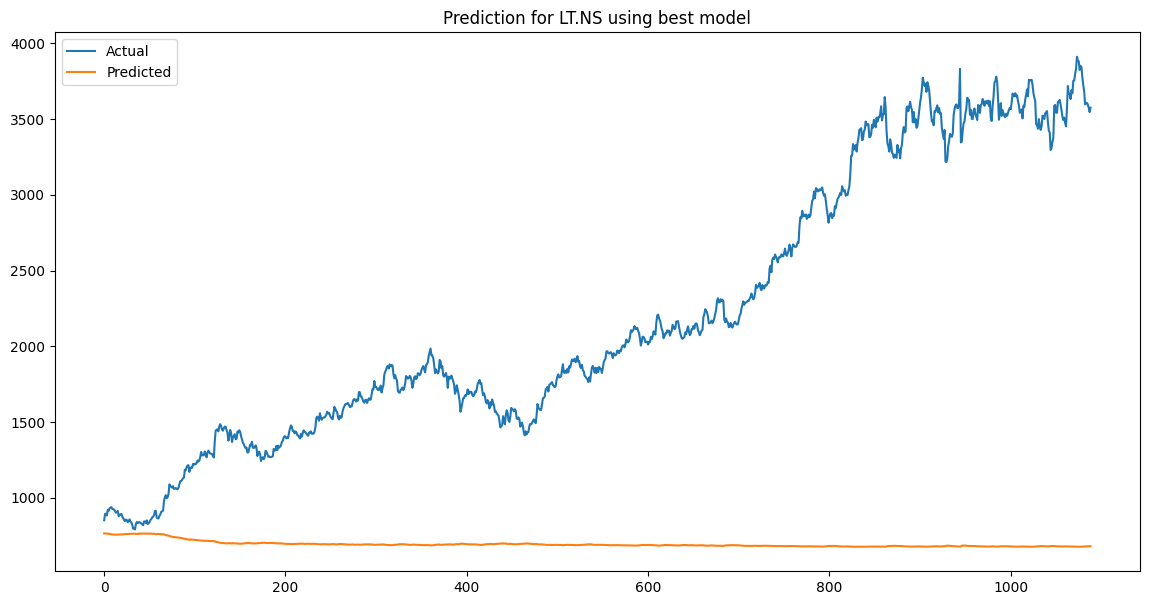

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

M&M.NS Latest Price: ₹3665.199951171875
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: BAJFINANCE.NS | R^2: -0.8387


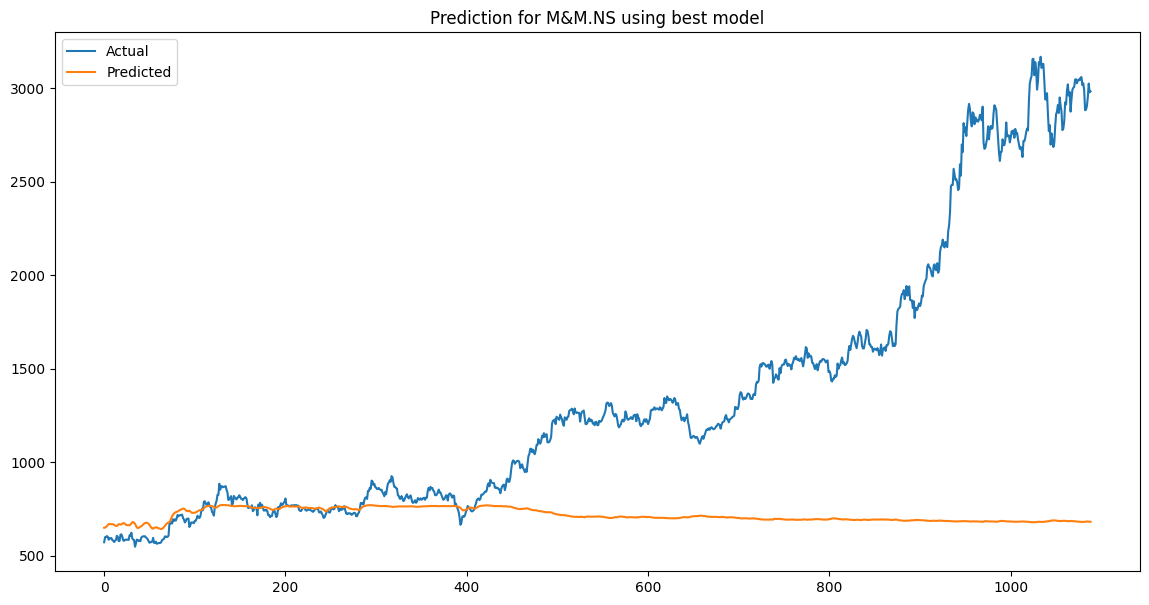

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


MARUTI.NS Latest Price: ₹16248.0
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: PAGEIND.NS | R^2: 0.8492


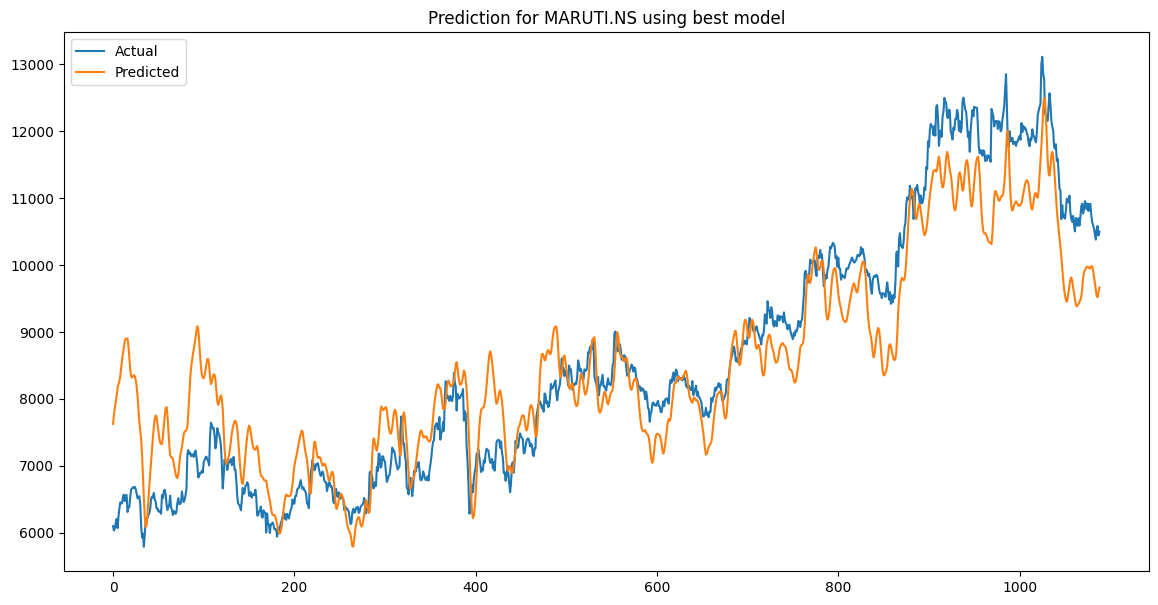

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


NTPC.NS Latest Price: ₹322.6000061035156
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: ITC.NS | R^2: 0.9924


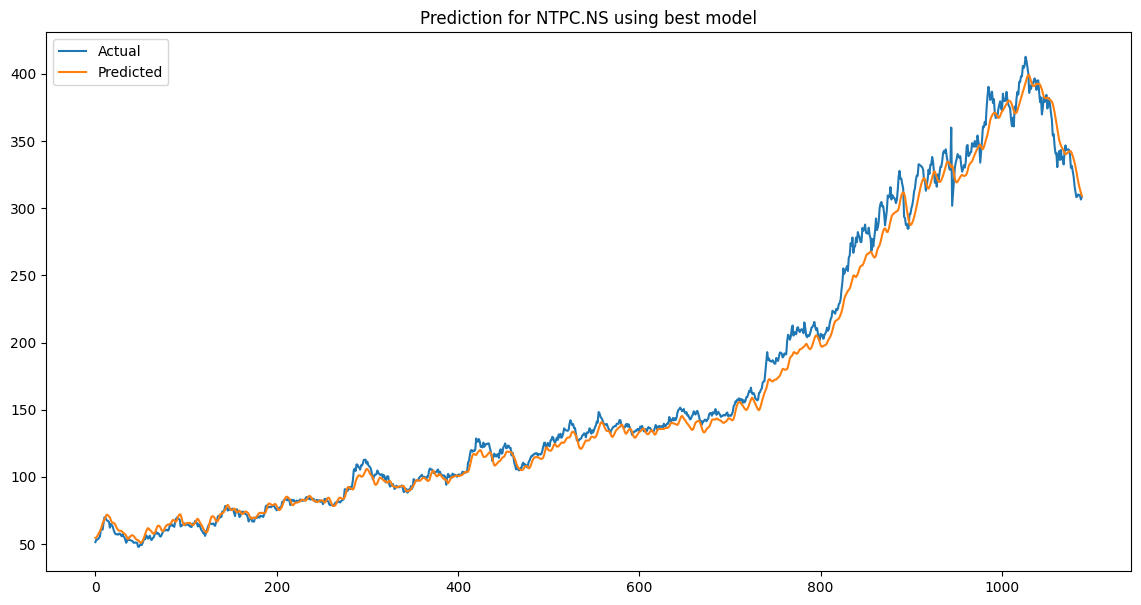

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


NESTLEIND.NS Latest Price: ₹1215.0
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Best Model: ICICIBANK.NS | R^2: 0.9785


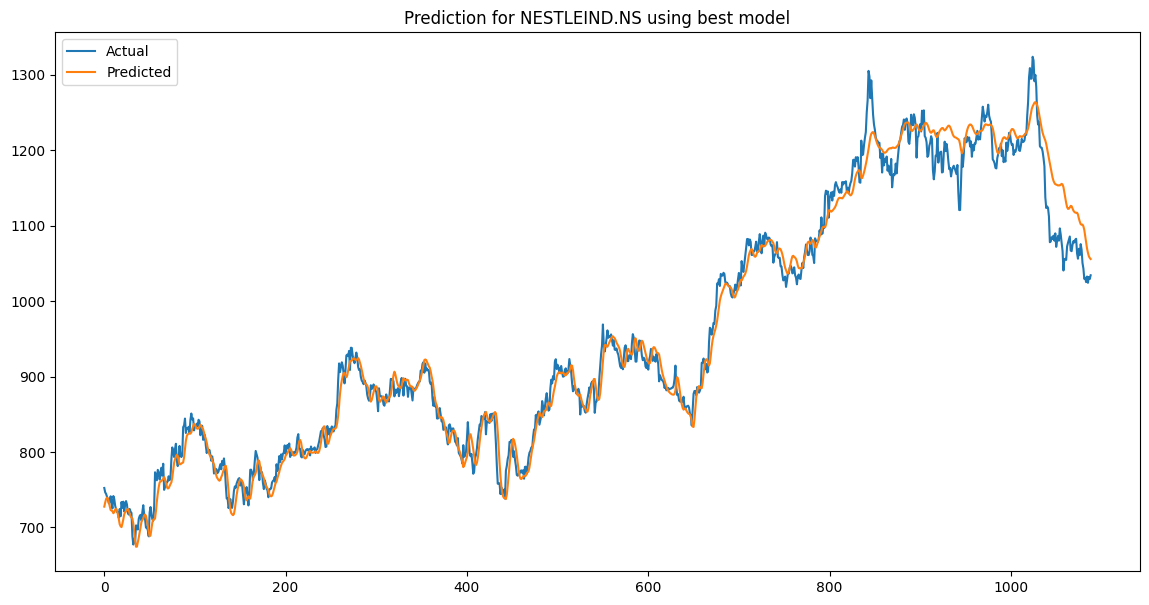

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


ONGC.NS Latest Price: ₹238.41000366210938
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: ITC.NS | R^2: 0.9852


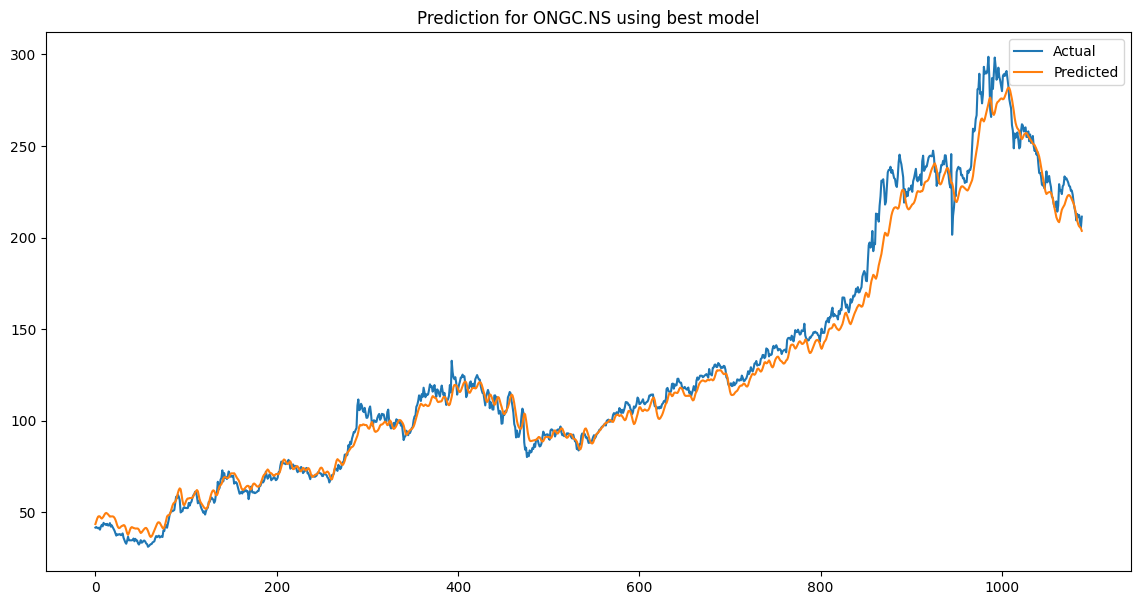

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


POWERGRID.NS Latest Price: ₹264.79998779296875
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: ITC.NS | R^2: 0.9904


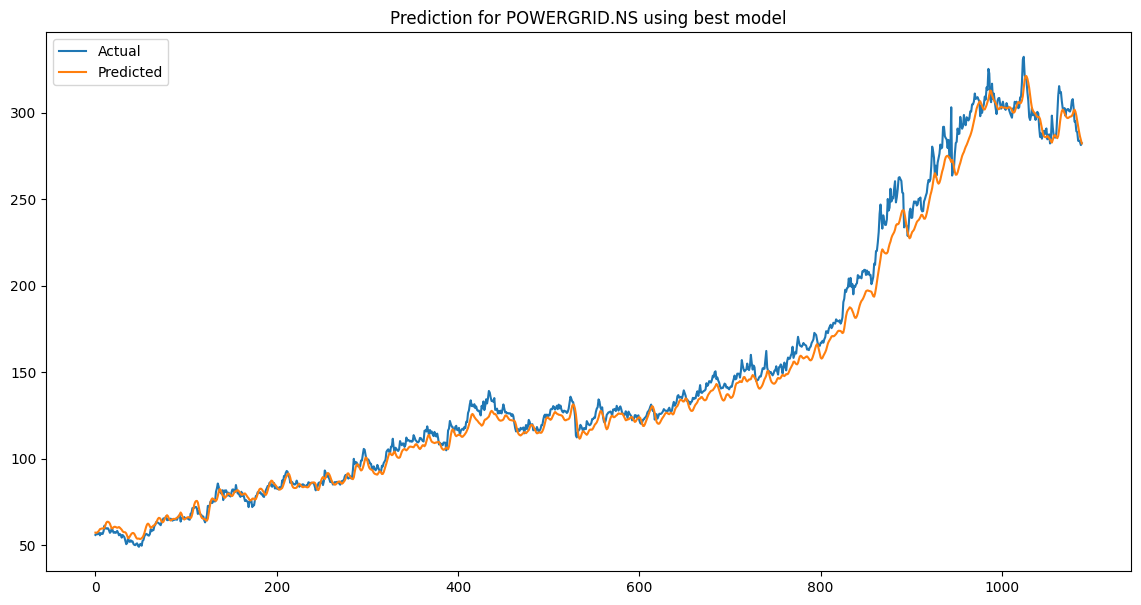

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


RELIANCE.NS Latest Price: ₹1545.0
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: ICICIBANK.NS | R^2: 0.8837


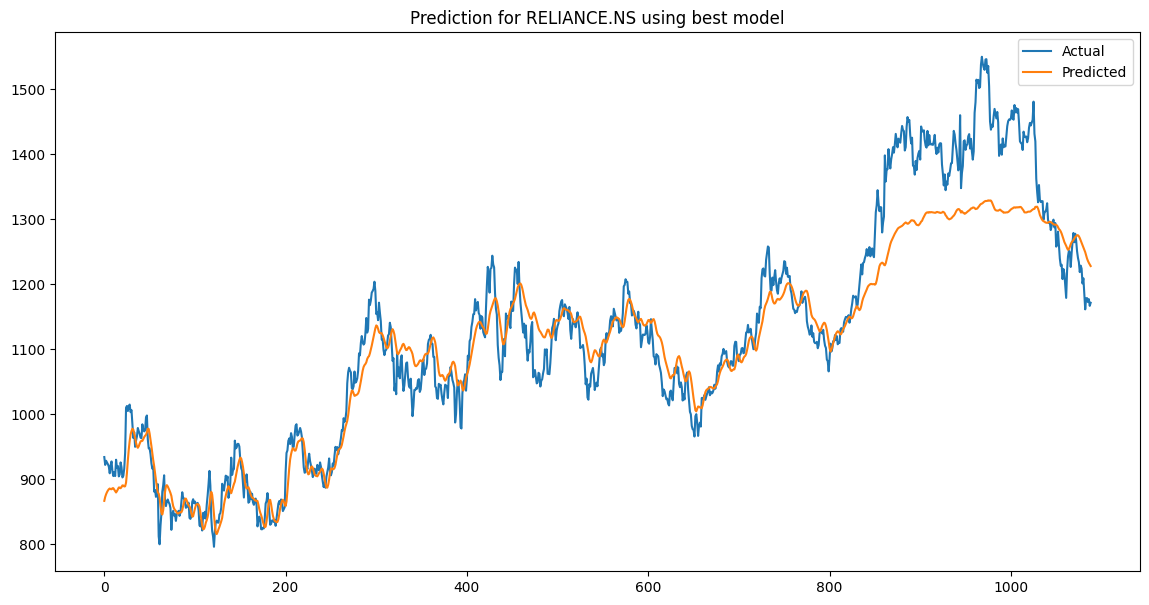

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


SBILIFE.NS Latest Price: ₹2006.9000244140625
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: SIEMENS.NS | R^2: 0.9754


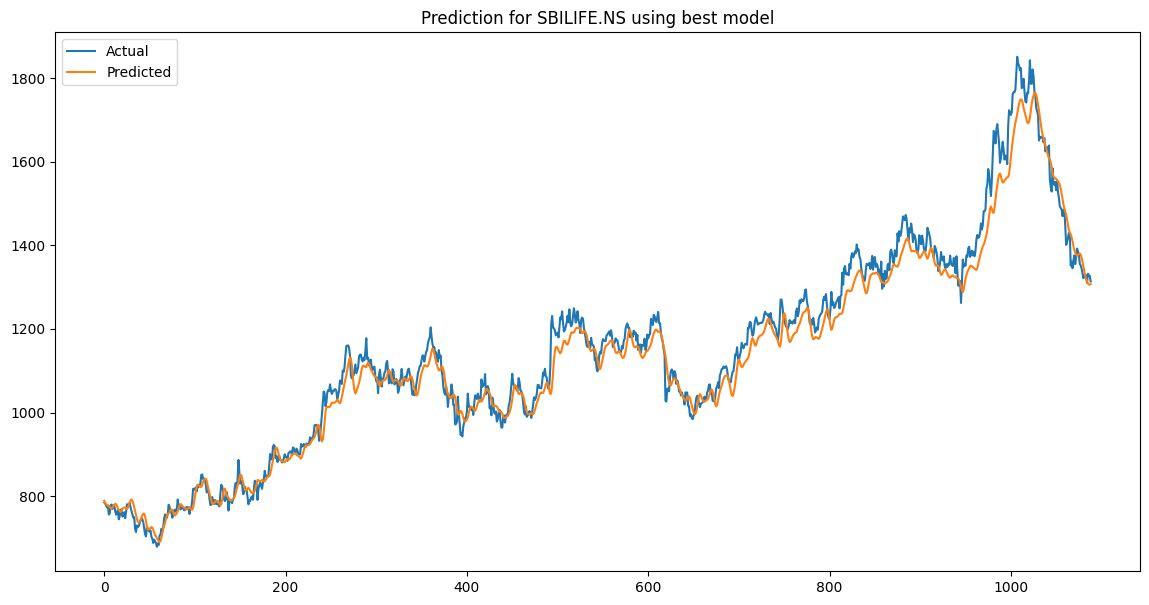

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


SBIN.NS Latest Price: ₹963.25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: ICICIBANK.NS | R^2: 0.9923


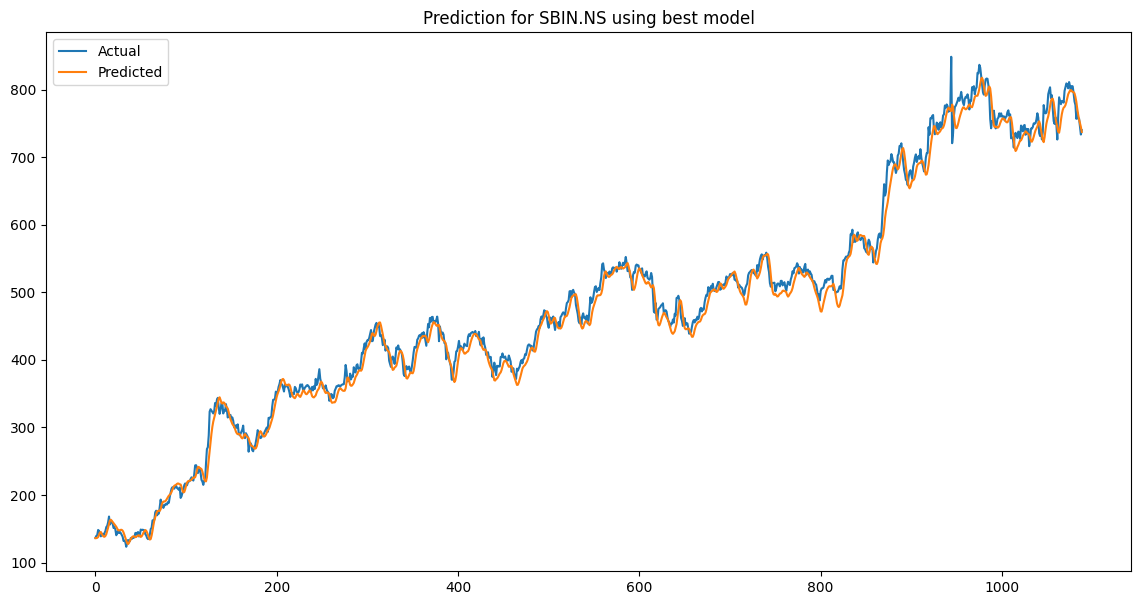

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


SUNPHARMA.NS Latest Price: ₹1807.199951171875
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: SIEMENS.NS | R^2: 0.9749


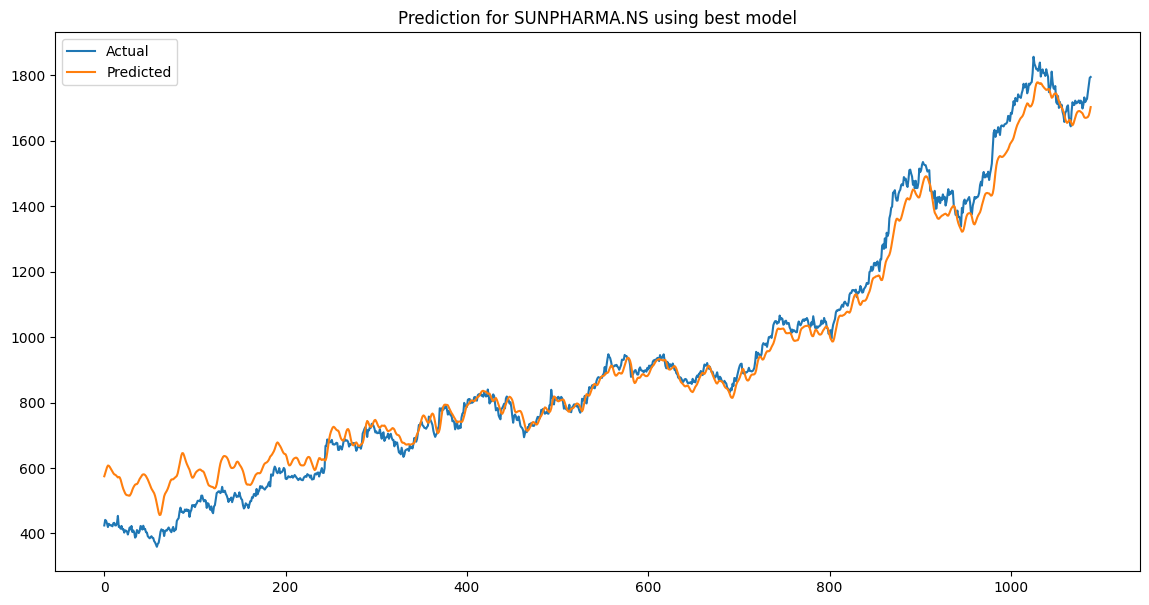

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

TCS.NS Latest Price: ₹3191.89990234375
 1/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: BAJFINANCE.NS | R^2: -25.4521


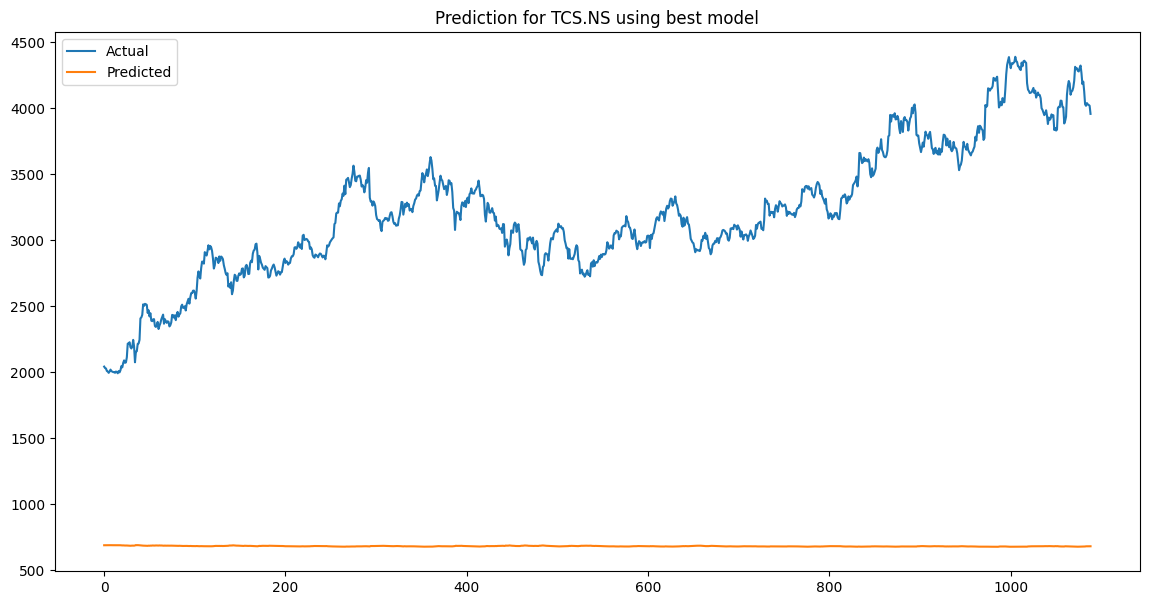

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

TATACONSUM.NS Latest Price: ₹1142.0999755859375
 1/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: ICICIBANK.NS | R^2: 0.9812


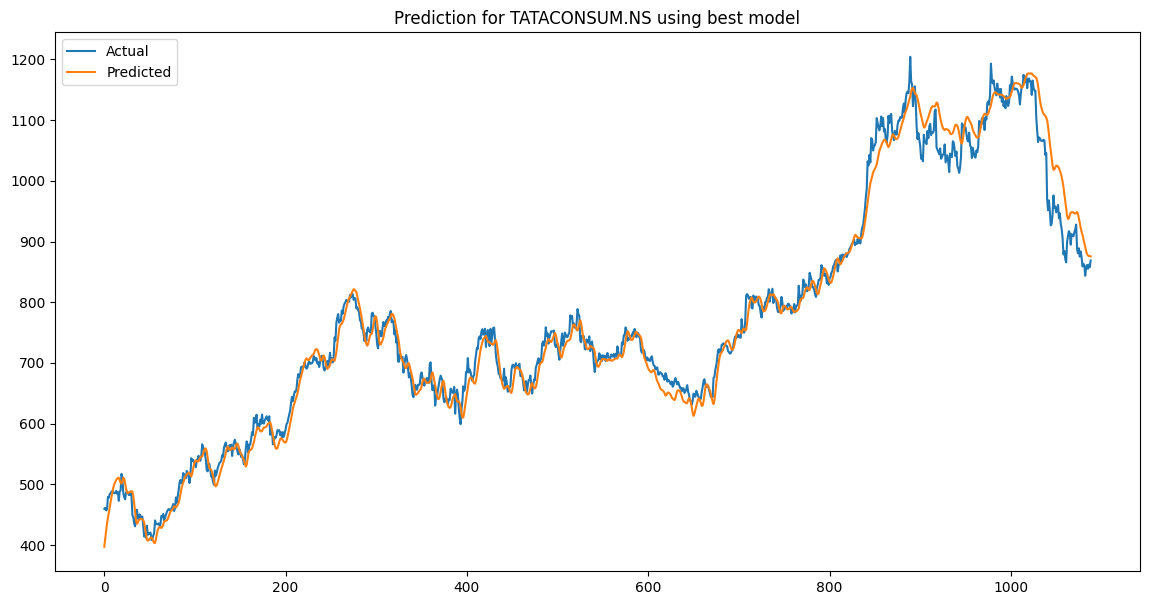

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


TATAMOTORS.NS Latest Price: ₹343.3999938964844
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: TATAMOTORS.NS | R^2: 0.9845


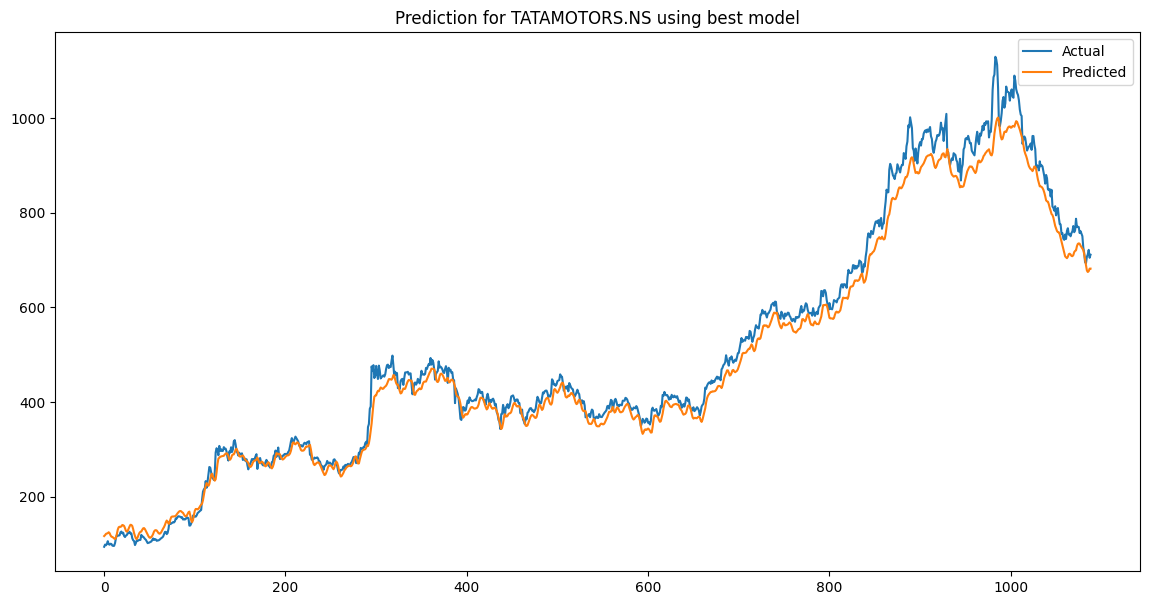

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


TATASTEEL.NS Latest Price: ₹166.3800048828125
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Best Model: ITC.NS | R^2: 0.8436


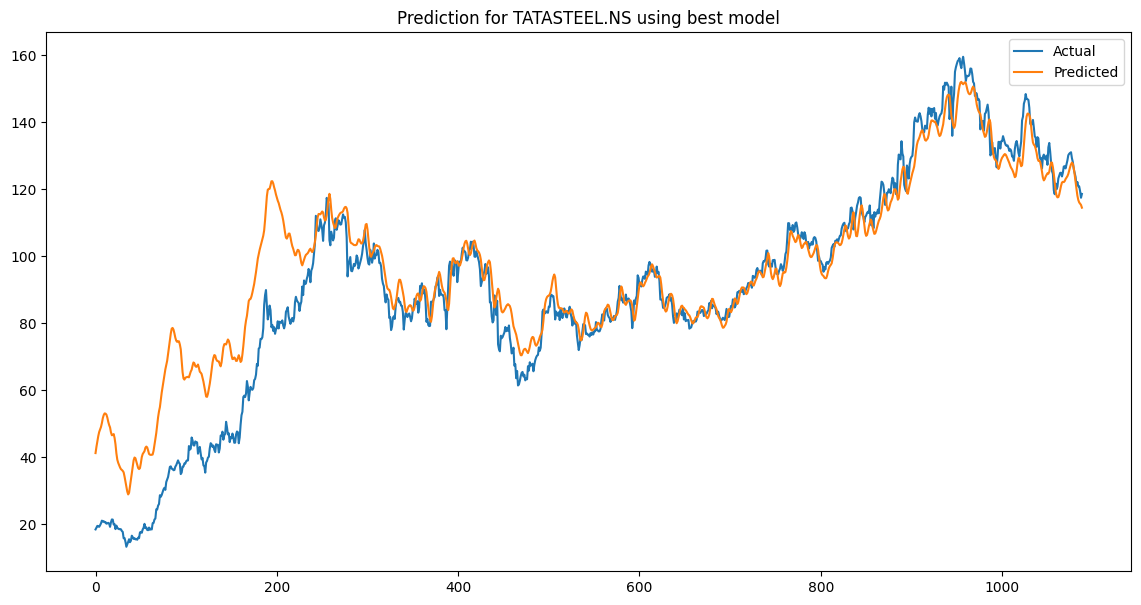

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


TECHM.NS Latest Price: ₹1568.199951171875


[*********************100%***********************]  1 of 1 completed


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: SIEMENS.NS | R^2: 0.9732


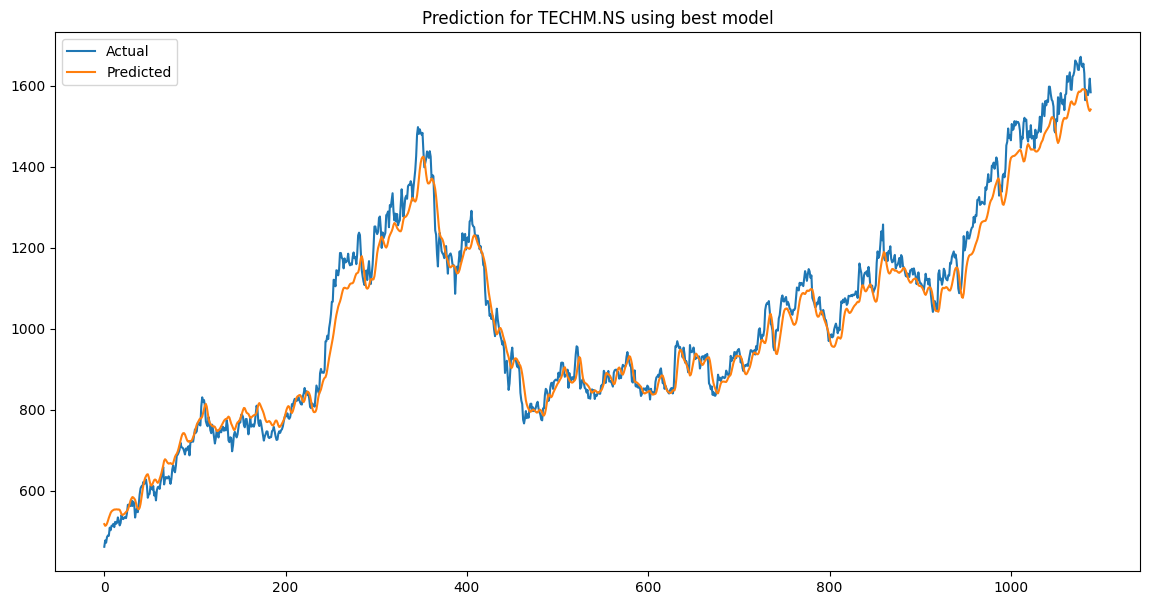

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


TITAN.NS Latest Price: ₹3844.800048828125


[*********************100%***********************]  1 of 1 completed

 7/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: BAJFINANCE.NS | R^2: -5.6765


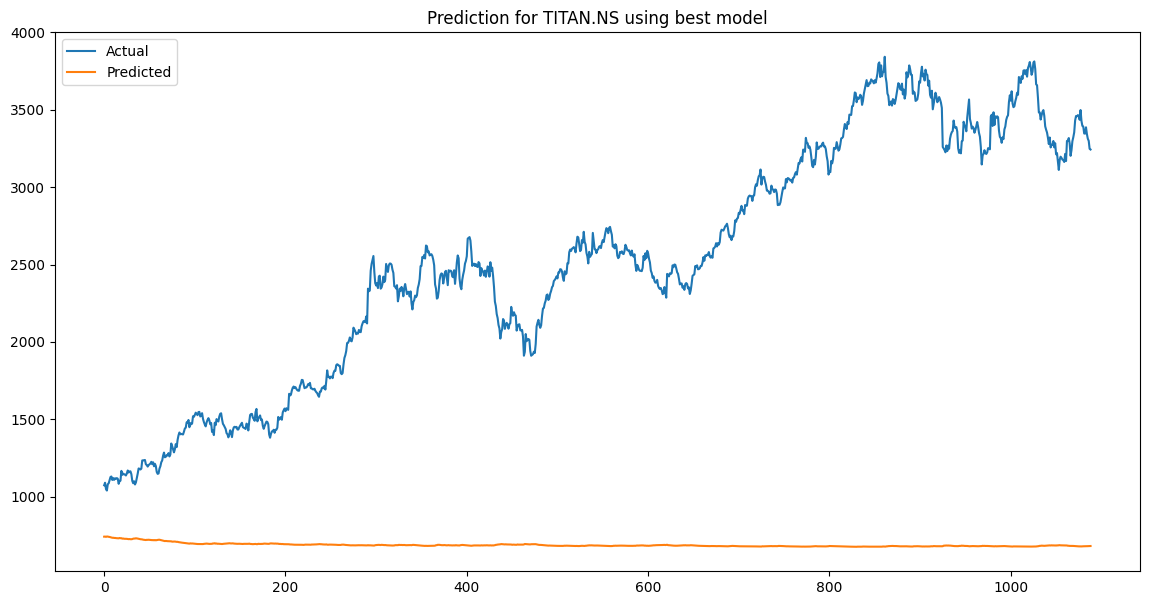

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


UPL.NS Latest Price: ₹745.8499755859375
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: TATAMOTORS.NS | R^2: 0.9132


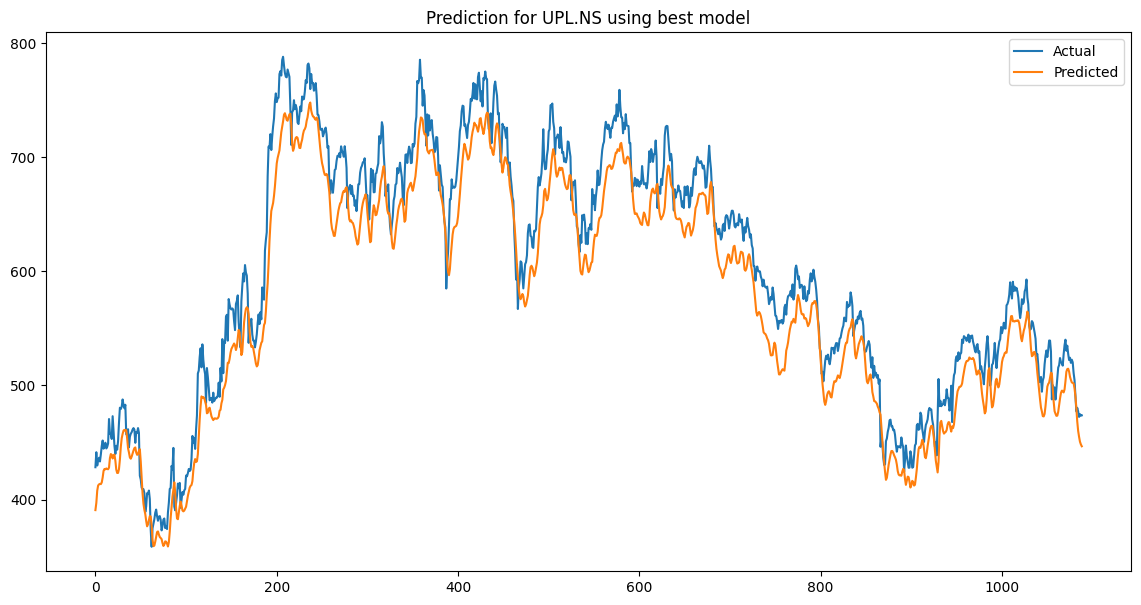

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


ULTRACEMCO.NS Latest Price: ₹11472.0


[*********************100%***********************]  1 of 1 completed

 7/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Model: PAGEIND.NS | R^2: 0.9408


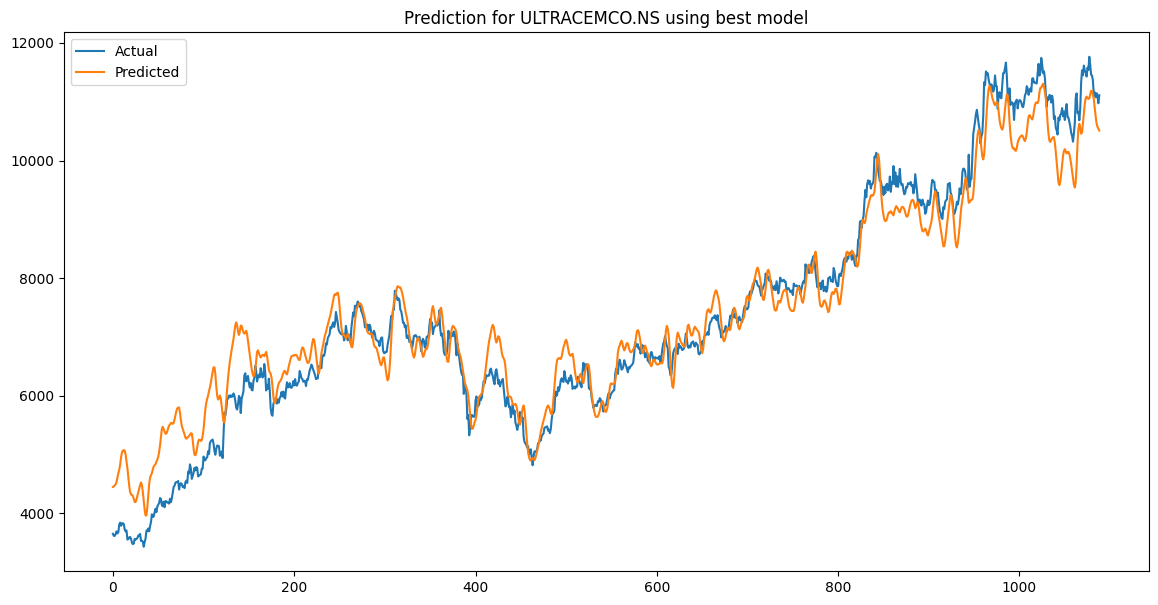

/tmp/ipython-input-2607696214.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_latest = yf.download(symbol, period="5d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2607696214.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_price = float(df_latest["Close"].iloc[-1])
/tmp/ipython-input-202100053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)


WIPRO.NS Latest Price: ₹259.25


[*********************100%***********************]  1 of 1 completed

 6/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Best Model: TATAMOTORS.NS | R^2: 0.9623


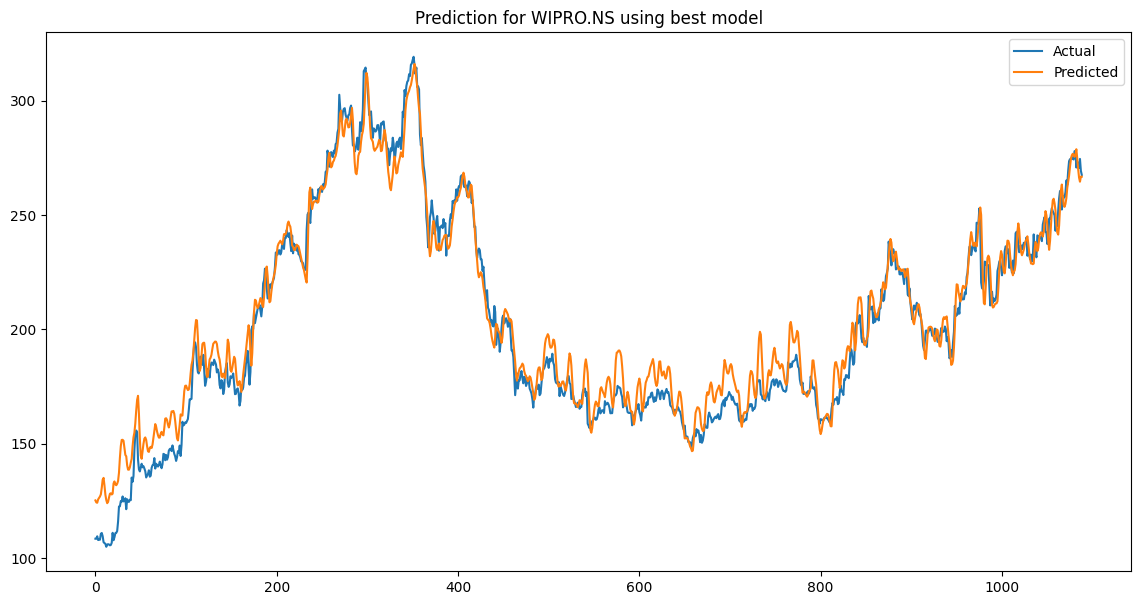

In [29]:
nifty_50_symbols = [
          "ADANIENT.NS", "ADANIPORTS.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS", "AXISBANK.NS",
          "BAJAJ-AUTO.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS", "BPCL.NS", "BHARTIARTL.NS",
          "BRITANNIA.NS", "CIPLA.NS", "COALINDIA.NS", "DIVISLAB.NS", "DRREDDY.NS",
          "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFCBANK.NS", "HEROMOTOCO.NS",
          "HINDALCO.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "ITC.NS", "INDUSINDBK.NS",
          "INFY.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LT.NS", "M&M.NS",
          "MARUTI.NS", "NTPC.NS", "NESTLEIND.NS", "ONGC.NS", "POWERGRID.NS",
          "RELIANCE.NS", "SBILIFE.NS", "SBIN.NS", "SUNPHARMA.NS", "TCS.NS",
          "TATACONSUM.NS", "TATAMOTORS.NS", "TATASTEEL.NS", "TECHM.NS", "TITAN.NS",
          "UPL.NS", "ULTRACEMCO.NS", "WIPRO.NS"
      ]

y_models = load_models(group_more)
x_models = load_models(group_less)
z_models= load_models(group_mid)

# for symbol in nifty_50_symbols:
#   prices_dict = yf.download(symbol, period="1d")['Close'].iloc[-1].to_dict()
#   price = list(prices_dict.values())[0] # Extract the price value from the dictionary

#   if price <= 800 :
#     predict_new_stock_best(symbol, "2020-01-01", "2025-01-01", trained_models=x_models)

#   elif price > 800 and price <= 3000 :
#     predict_new_stock_best(symbol, "2020-01-01", "2025-01-01", trained_models=z_models)

#   else :
#     predict_new_stock_best(symbol, "2020-01-01", "2025-01-01", trained_models=y_models)

for symbol in nifty_50_symbols:
    df_latest = yf.download(symbol, period="5d")

    # Skip if empty
    if df_latest.empty:
        print(f"{symbol} - No data found, skipping.")
        continue

    # Extract last closing price as a FLOAT
    latest_price = float(df_latest["Close"].iloc[-1])

    print(f"{symbol} Latest Price: ₹{latest_price}")

    # Choose model group
    if latest_price <= 800:
        models_group = x_models
    elif latest_price <= 3000:
        models_group = z_models
    else:
        models_group = y_models

    # Predict using selected model group
    predict_new_stock_best(
        symbol,
        start="2020-01-01",
        end="2025-01-01",
        trained_models=models_group
    )
